# TIMESERIES ANALYSIS

# Business Understanding

This project focuses on the application of time series regression analysis to forecast sales for Corporation Favorita, a prominent grocery retailer based in Ecuador.

The primary objective is to develop a robust model capable of accurately forecasting future sales by leveraging the extensive time series data of thousands of products sold across various Favorita locations. The resulting forecasts will provide valuable insights to the store's management, enabling them to formulate effective inventory and sales plans.

Through this research, we will construct models based on historical analysis, establish scientific hypothesis using time-stamped historical data, and employ these models to observe patterns and guide strategic decision-making in the future. By delving into the data, our aim is to optimize operations and ultimately drive sales growth for Favorita Corporation, supporting the management team in extracting meaningful insights from their vast dataset.

# Hypothesis

Null Hypothesis: Sales are not affected by promotion, oil prices and holidays.

Alternate Hypothesis: Sales are affected by promotion, oil prices and holidays.

# Analytical Questions

1. Is the train dataset complete (has all the required dates)?

2. Which dates have the lowest and highest sales for each year?

3. Did the earthquake impact sales?

4. Are certain groups of stores selling more products? (Cluster, city, state, type)

5. Are sales affected by promotions, oil prices and holidays?

6. What analysis can we get from the date and its extractable features?

7. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

In [91]:
# Importing the needed packages
import pandas as pd
import numpy as np
import matplotlib.dates as ndates

# Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries to create connection string to SQL server
import pyodbc
from dotenv import dotenv_values

# Library for imputing missing values
from sklearn.impute import SimpleImputer

# Library for seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Library for checking stationarity
from statsmodels.tsa.stattools import adfuller

# Library for modelling
from sklearn.linear_model import LinearRegression

# Library for working with operating system
import os

# Library to handle warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Set Matplotlib defaults
plt.style.use("seaborn-v0_8")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

# Data Understanding

### Accessing and loading the datasets

The first dataset was collected from a SQL database by first passing a connection string using the pyodbc library. Afterwards a SQL query was used to obtain the dataset. This is as shown below.

In [7]:
# Load the environment variable in the .env file into a dictionary

environment_variables = dotenv_values('.env')

# Get the values for the credentials you set in the .env file
server = environment_variables.get('SERVER')
database = environment_variables.get('DATABASE')
username = environment_variables.get('USERNAME')
password = environment_variables.get('PASSWORD')

# The connection string is an f string that includes all the variable above to establish a connection to the server.
connection_string = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}'

In [8]:
# Use the connect method of the pyodbc library to pass in the connection string.
# Check your internet connection if it takes more time than necessary.

connection = pyodbc.connect(connection_string)

# Get the oil dataset using the SQL query shown below
query1 = 'Select * from dbo.oil'
oil = pd.read_sql(query1, connection)

# Get the holiday dataset using the SQL query shown below
query2 = 'Select * from dbo.holidays_events'
holiday = pd.read_sql(query2, connection)

# Get the stores dataset using the SQL query shown below
query3 = 'Select * from dbo.stores'
stores = pd.read_sql(query3, connection)

# Save the datasets
oil.to_csv(r'oil.csv')
holiday.to_csv(r'holiday.csv')
stores.to_csv(r'stores.csv')

In [9]:
# Close connection

connection.close

<function Connection.close>

In [10]:
# Loading the other datasets

sample_submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
transactions = pd.read_csv('transactions.csv')

### EDA

In [11]:
# Evaluating the first five rows of the holiday dataset

holiday.head()

date     type    locale locale_name                    description   
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta  \
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [109]:
# Evaluating the first five rows of the oil dataset

oil.head()

date  dcoilwtico
0  2013-01-01   67.714366
1  2013-01-02   93.139999
2  2013-01-03   92.970001
3  2013-01-04   93.120003
4  2013-01-07   93.199997

<Axes: xlabel='date'>

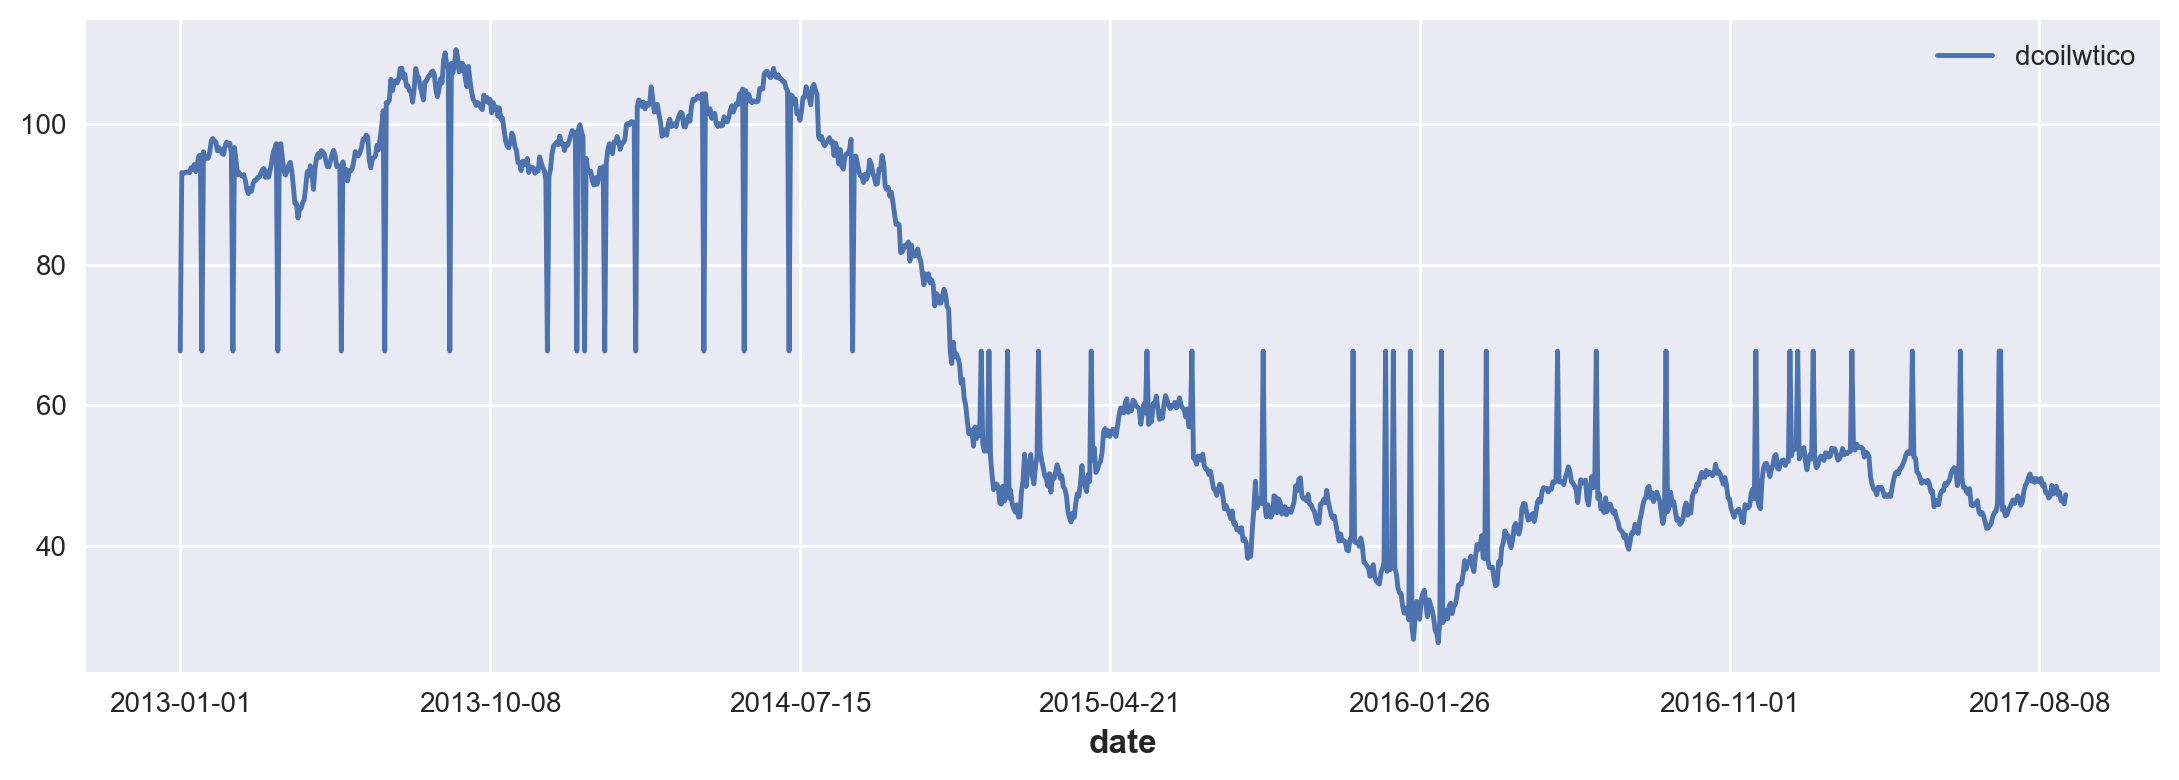

In [117]:
oil_df = oil.set_index('date')
oil_df.plot()

In [18]:
# Evaluating the first five rows of the stores dataset

stores.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [172]:
# Evaluating the first five rows of the transactions dataset

transactions.head()

date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111
2  2013-01-02          2          2358
3  2013-01-02          3          3487
4  2013-01-02          4          1922

In [173]:
# Evaluating the first five rows of the train dataset

train.head()

id        date  store_nbr      family  sales   onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0  No Promotion
1   1  2013-01-01          1   BABY CARE    0.0  No Promotion
2   2  2013-01-01          1      BEAUTY    0.0  No Promotion
3   3  2013-01-01          1   BEVERAGES    0.0  No Promotion
4   4  2013-01-01          1       BOOKS    0.0  No Promotion

In [174]:
# Evaluating the first five rows of the test dataset

test.head()

id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0
2  3000890  2017-08-16          1      BEAUTY            2
3  3000891  2017-08-16          1   BEVERAGES           20
4  3000892  2017-08-16          1       BOOKS            0

In [21]:
# Evaluating the first five rows of the sample_submission dataset

sample_submission.head()

id  sales
0  3000888    0.0
1  3000889    0.0
2  3000890    0.0
3  3000891    0.0
4  3000892    0.0

In [119]:
# Create a dictionary of the datasets

data = {'holiday': holiday, 'oil': oil, 'stores': stores, 'transactions': transactions, 'train': train, 'test': test, 'sample_submission': sample_submission}

In [171]:
# Check the datatypes and presence of missing values in each of the datasets
# Use '\033[1mtext\033[0m' to make text bold

for df, dataset in data.items():
    print(f'\033[1mFor {df} dataset\033[0m:')
    dataset.info()
    print('_'*45)
    print('\n')

For holiday dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
_____________________________________________


For oil dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1218 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB
_____________________________________________


For stores dataset:
<class 'pandas.core.frame.DataFrame'>
Ran

In [175]:
# Check the shape, and the presence of missing values and duplicates in each of the datasets
# Use '\033[1mtext\033[0m' to make text bold

for df, dataset in data.items():
    print(f'\033[1mFor {df} dataset\033[0m')
    print(f'Shape: {dataset.shape}')
    print(f'Missing values = {dataset.isna().sum().sum()}')
    print(f'Duplicates = {dataset.duplicated().sum()}')
    print('_'*30)
    print('\n')

For holiday dataset
Shape: (350, 6)
Missing values = 0
Duplicates = 0
______________________________


For oil dataset
Shape: (1218, 2)
Missing values = 0
Duplicates = 0
______________________________


For stores dataset
Shape: (54, 5)
Missing values = 0
Duplicates = 0
______________________________


For transactions dataset
Shape: (83488, 3)
Missing values = 0
Duplicates = 0
______________________________


For train dataset
Shape: (3000888, 6)
Missing values = 0
Duplicates = 0
______________________________


For test dataset
Shape: (28512, 5)
Missing values = 0
Duplicates = 0
______________________________


For sample_submission dataset
Shape: (28512, 2)
Missing values = 0
Duplicates = 0
______________________________




# Problems Identified

The oil dataset has 43 missing values on the 'dcoilwtico' column.

The datasets are seperate, and need to be merged together for better analysis.

For all the datasets that have a 'date' column, the 'date' column is present as object datatype instead of datetime datatype.

# Data Preparation

The problems identified with the datasets will be handled to prepare the data for analysis and modelling.

### Filling missing values

In [34]:
# create an instance of the SimpleImputer class with mean strategy
imputer = SimpleImputer(strategy='mean')

# fit the imputer to the 'dcoilwtico' column of oil dataset
imputer.fit(oil[['dcoilwtico']])

# Impute missing values on the 'dcoilwtico' column of oil dataset with the imputer
oil['dcoilwtico'] = imputer.transform(oil[['dcoilwtico']])

oil.head()

date  dcoilwtico
0  2013-01-01   67.714366
1  2013-01-02   93.139999
2  2013-01-03   92.970001
3  2013-01-04   93.120003
4  2013-01-07   93.199997

### Merge the datasets based on common columns

In [35]:
# Merge transactions dataset to train on 'date' and 'store_nbr' columns
df1 = pd.merge(train, transactions, on=['date', 'store_nbr'])

# Merge holiday dataset to df1 on 'date' column
df2 = pd.merge(df1, holiday, on='date')

# Merge oil dataset to df2 on 'date' column
df3 = pd.merge(df2, oil, on='date')
df3

# Merge store dataset to df3 on 'store_nbr' column
df4 = pd.merge(df3, stores, on='store_nbr')

df4.head()

id        date  store_nbr      family  sales  onpromotion  transactions   
0  561  2013-01-01         25  AUTOMOTIVE    0.0            0           770  \
1  562  2013-01-01         25   BABY CARE    0.0            0           770   
2  563  2013-01-01         25      BEAUTY    2.0            0           770   
3  564  2013-01-01         25   BEVERAGES  810.0            0           770   
4  565  2013-01-01         25       BOOKS    0.0            0           770   

    type_x    locale locale_name         description  transferred  dcoilwtico   
0  Holiday  National     Ecuador  Primer dia del ano        False   67.714366  \
1  Holiday  National     Ecuador  Primer dia del ano        False   67.714366   
2  Holiday  National     Ecuador  Primer dia del ano        False   67.714366   
3  Holiday  National     Ecuador  Primer dia del ano        False   67.714366   
4  Holiday  National     Ecuador  Primer dia del ano        False   67.714366   

      city        state type_y  cluster  
0  Salinas  Santa Elena      D        1  
1  Salinas  Santa Elena      D        1  
2  Salinas  Santa Elena      D        1  
3  Salinas  Santa Elena      D        1  
4  Salinas  Santa Elena      D        1

### Change the datatype of the 'date' column from object to datetime

In [36]:
df4['date'] = pd.to_datetime(df4['date'])

df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            322047 non-null  int64         
 1   date          322047 non-null  datetime64[ns]
 2   store_nbr     322047 non-null  int64         
 3   family        322047 non-null  object        
 4   sales         322047 non-null  float64       
 5   onpromotion   322047 non-null  int64         
 6   transactions  322047 non-null  int64         
 7   type_x        322047 non-null  object        
 8   locale        322047 non-null  object        
 9   locale_name   322047 non-null  object        
 10  description   322047 non-null  object        
 11  transferred   322047 non-null  bool          
 12  dcoilwtico    322047 non-null  float64       
 13  city          322047 non-null  object        
 14  state         322047 non-null  object        
 15  type_y        322

The missing values in the 'dcoilwtico' column of the oil dataset have been filled, the datasets have been merged and the datatype of the 'date' column has been changed from object to datetime.

In [37]:
# Evaluating 'type_x' column on df4

df4['type_x'].unique()

array(['Holiday', 'Additional', 'Transfer', 'Event', 'Bridge'],
      dtype=object)

In [38]:
# Evaluating 'type_y' column on df4

df4['type_y'].unique()

array(['D', 'C', 'B', 'E', 'A'], dtype=object)

In [98]:
# Rename 'type_x' and type_y' to 'holiday_type' and 'store_type' respectively

df4 = df4.rename(columns={'type_x': 'holiday_type', 'type_y': 'store_type'})
df4.head()

id  store_nbr      family  sales  onpromotion  transactions   
date                                                                       
2013-01-01  561         25  AUTOMOTIVE    0.0            0           770  \
2013-01-01  562         25   BABY CARE    0.0            0           770   
2013-01-01  563         25      BEAUTY    2.0            0           770   
2013-01-01  564         25   BEVERAGES  810.0            0           770   
2013-01-01  565         25       BOOKS    0.0            0           770   

           holiday_type    locale locale_name         description  ...   
date                                                               ...   
2013-01-01      Holiday  National     Ecuador  Primer dia del ano  ...  \
2013-01-01      Holiday  National     Ecuador  Primer dia del ano  ...   
2013-01-01      Holiday  National     Ecuador  Primer dia del ano  ...   
2013-01-01      Holiday  National     Ecuador  Primer dia del ano  ...   
2013-01-01      Holiday  National     Ecuador  Primer dia del ano  ...   

            dcoilwtico     city        state store_type cluster  year  month   
date                                                                           
2013-01-01   67.714366  Salinas  Santa Elena          D       1  2013      1  \
2013-01-01   67.714366  Salinas  Santa Elena          D       1  2013      1   
2013-01-01   67.714366  Salinas  Santa Elena          D       1  2013      1   
2013-01-01   67.714366  Salinas  Santa Elena          D       1  2013      1   
2013-01-01   67.714366  Salinas  Santa Elena          D       1  2013      1   

            dayofmonth  dayofweek  dayname  
date                                        
2013-01-01           1          1  Tuesday  
2013-01-01           1          1  Tuesday  
2013-01-01           1          1  Tuesday  
2013-01-01           1          1  Tuesday  
2013-01-01           1          1  Tuesday  

[5 rows x 21 columns]

In [99]:
# Checking for the frequency of the 'date' column

pd.date_range('2013-01-01','2013-01-31', freq='D')

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10', '2013-01-11', '2013-01-12',
               '2013-01-13', '2013-01-14', '2013-01-15', '2013-01-16',
               '2013-01-17', '2013-01-18', '2013-01-19', '2013-01-20',
               '2013-01-21', '2013-01-22', '2013-01-23', '2013-01-24',
               '2013-01-25', '2013-01-26', '2013-01-27', '2013-01-28',
               '2013-01-29', '2013-01-30', '2013-01-31'],
              dtype='datetime64[ns]', freq='D')

The result above shows that the 'date' column exists in daily frequency.

In [94]:
# Create new features from the 'date' column using pandas' powerful time-based indexing

df4['year'] = df4.date.dt.year
df4['month'] = df4.date.dt.month
df4['dayofmonth'] = df4.date.dt.day
df4['dayofweek'] = df4.date.dt.dayofweek
df4['dayname'] = df4.date.dt.strftime('%A')

df4.head()

id       date  store_nbr      family  sales  onpromotion  transactions   
0  561 2013-01-01         25  AUTOMOTIVE    0.0            0           770  \
1  562 2013-01-01         25   BABY CARE    0.0            0           770   
2  563 2013-01-01         25      BEAUTY    2.0            0           770   
3  564 2013-01-01         25   BEVERAGES  810.0            0           770   
4  565 2013-01-01         25       BOOKS    0.0            0           770   

  holiday_type    locale locale_name  ... dcoilwtico     city        state   
0      Holiday  National     Ecuador  ...  67.714366  Salinas  Santa Elena  \
1      Holiday  National     Ecuador  ...  67.714366  Salinas  Santa Elena   
2      Holiday  National     Ecuador  ...  67.714366  Salinas  Santa Elena   
3      Holiday  National     Ecuador  ...  67.714366  Salinas  Santa Elena   
4      Holiday  National     Ecuador  ...  67.714366  Salinas  Santa Elena   

  store_type cluster  year  month  dayofmonth  dayofweek  dayname  
0          D       1  2013      1           1          1  Tuesday  
1          D       1  2013      1           1          1  Tuesday  
2          D       1  2013      1           1          1  Tuesday  
3          D       1  2013      1           1          1  Tuesday  
4          D       1  2013      1           1          1  Tuesday  

[5 rows x 22 columns]

In [96]:
# Set the 'date' column as index

df4 = df4.set_index('date')
df4.head()

id  store_nbr      family  sales  onpromotion  transactions   
date                                                                       
2013-01-01  561         25  AUTOMOTIVE    0.0            0           770  \
2013-01-01  562         25   BABY CARE    0.0            0           770   
2013-01-01  563         25      BEAUTY    2.0            0           770   
2013-01-01  564         25   BEVERAGES  810.0            0           770   
2013-01-01  565         25       BOOKS    0.0            0           770   

           holiday_type    locale locale_name         description  ...   
date                                                               ...   
2013-01-01      Holiday  National     Ecuador  Primer dia del ano  ...  \
2013-01-01      Holiday  National     Ecuador  Primer dia del ano  ...   
2013-01-01      Holiday  National     Ecuador  Primer dia del ano  ...   
2013-01-01      Holiday  National     Ecuador  Primer dia del ano  ...   
2013-01-01      Holiday  National     Ecuador  Primer dia del ano  ...   

            dcoilwtico     city        state store_type cluster  year  month   
date                                                                           
2013-01-01   67.714366  Salinas  Santa Elena          D       1  2013      1  \
2013-01-01   67.714366  Salinas  Santa Elena          D       1  2013      1   
2013-01-01   67.714366  Salinas  Santa Elena          D       1  2013      1   
2013-01-01   67.714366  Salinas  Santa Elena          D       1  2013      1   
2013-01-01   67.714366  Salinas  Santa Elena          D       1  2013      1   

            dayofmonth  dayofweek  dayname  
date                                        
2013-01-01           1          1  Tuesday  
2013-01-01           1          1  Tuesday  
2013-01-01           1          1  Tuesday  
2013-01-01           1          1  Tuesday  
2013-01-01           1          1  Tuesday  

[5 rows x 21 columns]

In [40]:
# Rename df4 to train_data and save the DataFrame

train_merged = df4
train_merged.to_csv(r'train_merged.csv')

In [95]:
# Display random sample of 8 rows

train_merged.sample(8, random_state = 42)

id  store_nbr           family    sales  onpromotion   
date                                                                    
2017-05-12  2830580         30     BREAD/BAKERY  143.000            2  \
2013-11-06   551707         39       GROCERY II   28.000            0   
2017-03-02  2704338         38         LINGERIE    8.000            0   
2016-05-13  2184356         48  LAWN AND GARDEN    6.000            0   
2013-06-25   312431         25  LAWN AND GARDEN    2.000            0   
2017-08-15  2999214         12             DELI  145.000            6   
2015-11-02  1841725         34          POULTRY  145.608            0   
2015-08-10  1692472         47        BABY CARE    0.000            0   

            transactions holiday_type    locale   
date                                              
2017-05-12           743      Holiday     Local  \
2013-11-06          1275      Holiday  Regional   
2017-03-02          1426      Holiday     Local   
2016-05-13          2438        Event  National   
2013-06-25           515      Holiday     Local   
2017-08-15          1096      Holiday     Local   
2015-11-02          1766      Holiday  National   
2015-08-10          4049      Holiday  National   

                               locale_name   
date                                         
2017-05-12                            Puyo  \
2013-11-06  Santo Domingo de los Tsachilas   
2017-03-02                           Manta   
2016-05-13                         Ecuador   
2013-06-25                       Latacunga   
2017-08-15                        Riobamba   
2015-11-02                         Ecuador   
2015-08-10                         Ecuador   

                                   description  ...  dcoilwtico       city   
date                                            ...                          
2017-05-12              Cantonizacion del Puyo  ...   47.830002  Guayaquil  \
2013-11-06  Provincializacion de Santo Domingo  ...   94.739998     Cuenca   
2017-03-02                  Fundacion de Manta  ...   52.630001       Loja   
2016-05-13                 Terremoto Manabi+27  ...   46.220001      Quito   
2013-06-25          Cantonizacion de Latacunga  ...   95.250000    Salinas   
2017-08-15               Fundacion de Riobamba  ...   47.570000  Latacunga   
2015-11-02                     Dia de Difuntos  ...   46.119999  Guayaquil   
2015-08-10       Primer Grito de Independencia  ...   44.939999      Quito   

                  state store_type cluster  year  month  dayofmonth   
date                                                                  
2017-05-12       Guayas          C       3  2017      5          12  \
2013-11-06        Azuay          B       6  2013     11           6   
2017-03-02         Loja          D       4  2017      3           2   
2016-05-13    Pichincha          A      14  2016      5          13   
2013-06-25  Santa Elena          D       1  2013      6          25   
2017-08-15     Cotopaxi          C      15  2017      8          15   
2015-11-02       Guayas          B       6  2015     11           2   
2015-08-10    Pichincha          A      14  2015      8          10   

            dayofweek    dayname  
date                              
2017-05-12          4     Friday  
2013-11-06          2  Wednesday  
2017-03-02          3   Thursday  
2016-05-13          4     Friday  
2013-06-25          1    Tuesday  
2017-08-15          1    Tuesday  
2015-11-02          0     Monday  
2015-08-10          0     Monday  

[8 rows x 21 columns]

In [41]:
# Generate summary statistics for numerical columns in train_data DataFrame

train_merged.describe()

id                           date      store_nbr   
count  3.220470e+05                         322047  322047.000000  \
mean   1.682979e+06  2015-08-04 23:49:57.971103488      26.994672   
min    5.610000e+02            2013-01-01 00:00:00       1.000000   
25%    1.010616e+06            2014-07-23 00:00:00      13.000000   
50%    1.842406e+06            2015-11-02 00:00:00      27.000000   
75%    2.209556e+06            2016-05-27 00:00:00      40.000000   
max    3.000887e+06            2017-08-15 00:00:00      54.000000   
std    7.862493e+05                            NaN      15.595174   

               sales    onpromotion   transactions     dcoilwtico   
count  322047.000000  322047.000000  322047.000000  322047.000000  \
mean      406.383452       3.727136    1734.117840      64.326826   
min         0.000000       0.000000      54.000000      27.959999   
25%         1.000000       0.000000    1030.000000      44.939999   
50%        19.000000       0.000000    1409.000000      52.720001   
75%       241.260505       1.000000    2148.000000      93.120003   
max    124717.000000     716.000000    8359.000000     107.949997   
std      1246.881240      15.512095    1050.335018      24.289114   

             cluster  
count  322047.000000  
mean        8.531202  
min         1.000000  
25%         4.000000  
50%         9.000000  
75%        13.000000  
max        17.000000  
std         4.713809

Text(0.5, 0, 'Year')

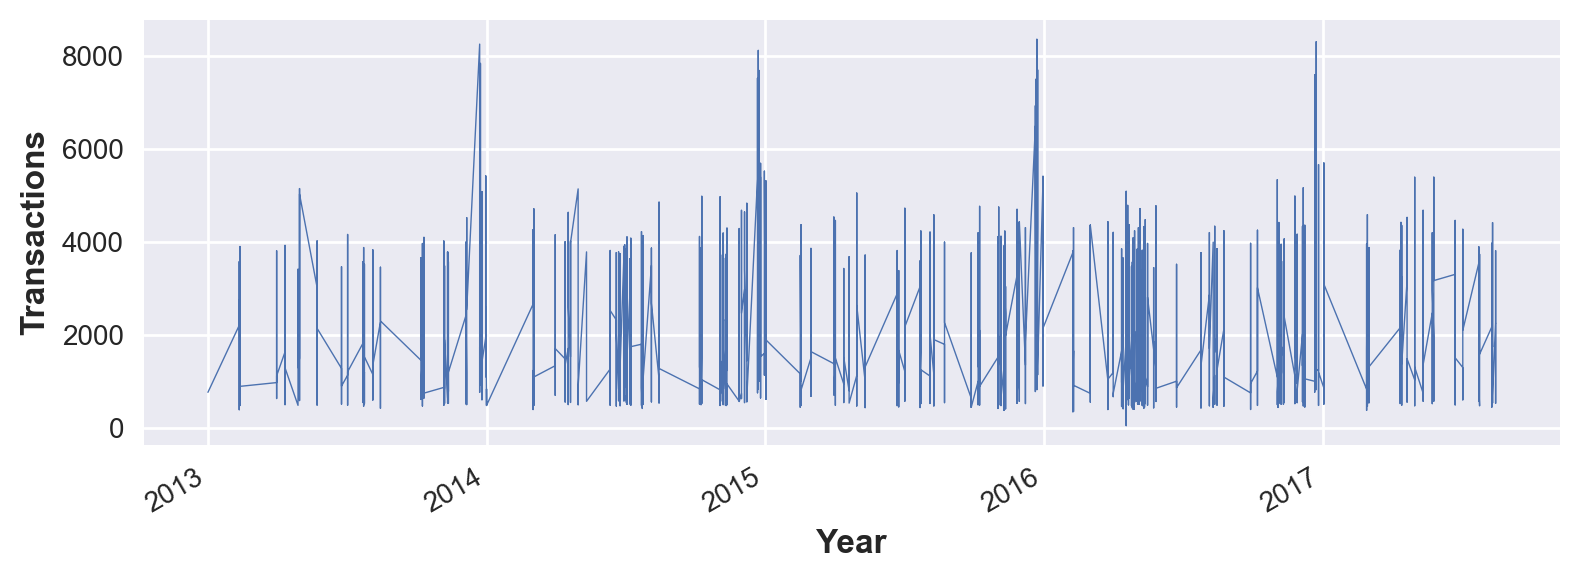

In [100]:
# Visualize the 'transactions' column

plt.figure(figsize=(8,3))
ax = train_merged['transactions'].plot(linewidth=0.5)
ax.set_ylabel('Transactions')
ax.set_xlabel('Year')

The plot above reveals that transactions are always highest at the end of each year. This reveals seasonality in the dataset.

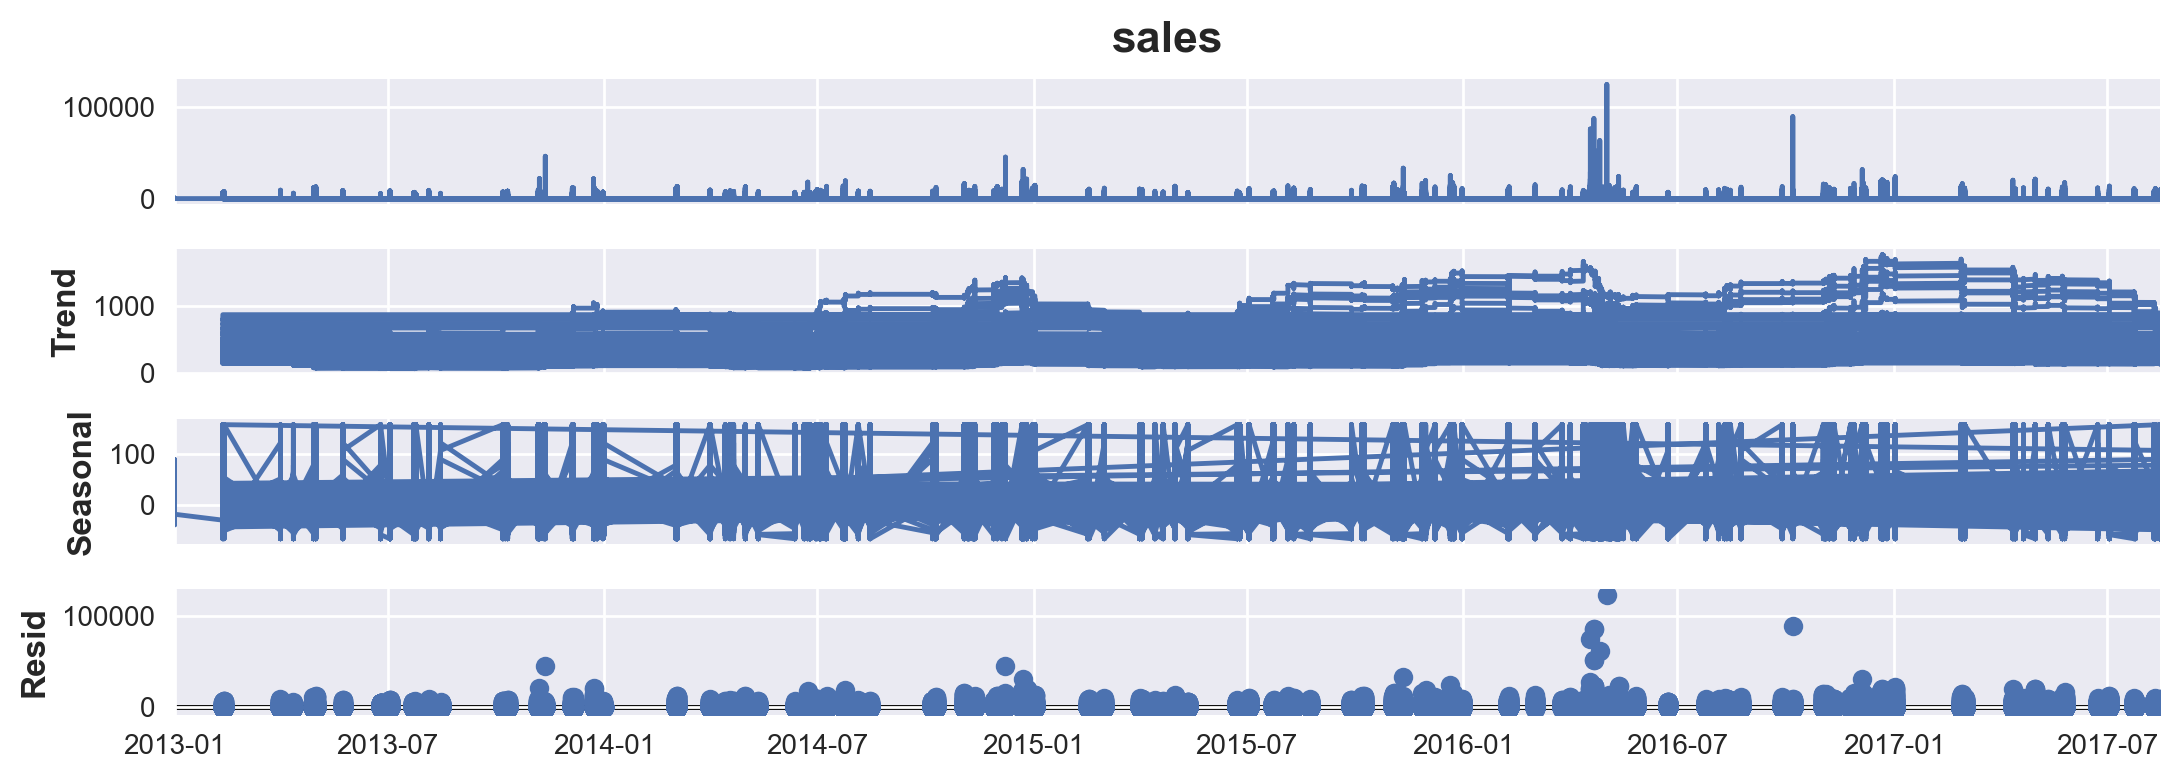

In [101]:
# Perform seasonal decomposition

result = seasonal_decompose(train_merged['sales'], model='additive', period=365)
result.plot()
plt.show()

In [102]:
# # Check for stationarity using adfuller

# result = adfuller(train_merged['transactions'])

# print(f'Test Statistics: {result[0]}')
# print(f'p-value: {result[1]}')
# print(f'Critical Values: {result[4]}')

# if result[1] > 0.05 :
#     print('Series is not stationary')
# else:
#     print('Series is stationary')

In [103]:
# # Create an autocorrelation plot

# pd.plotting.autocorrelation_plot(train_merged['2013':'2017']['transactions'])

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

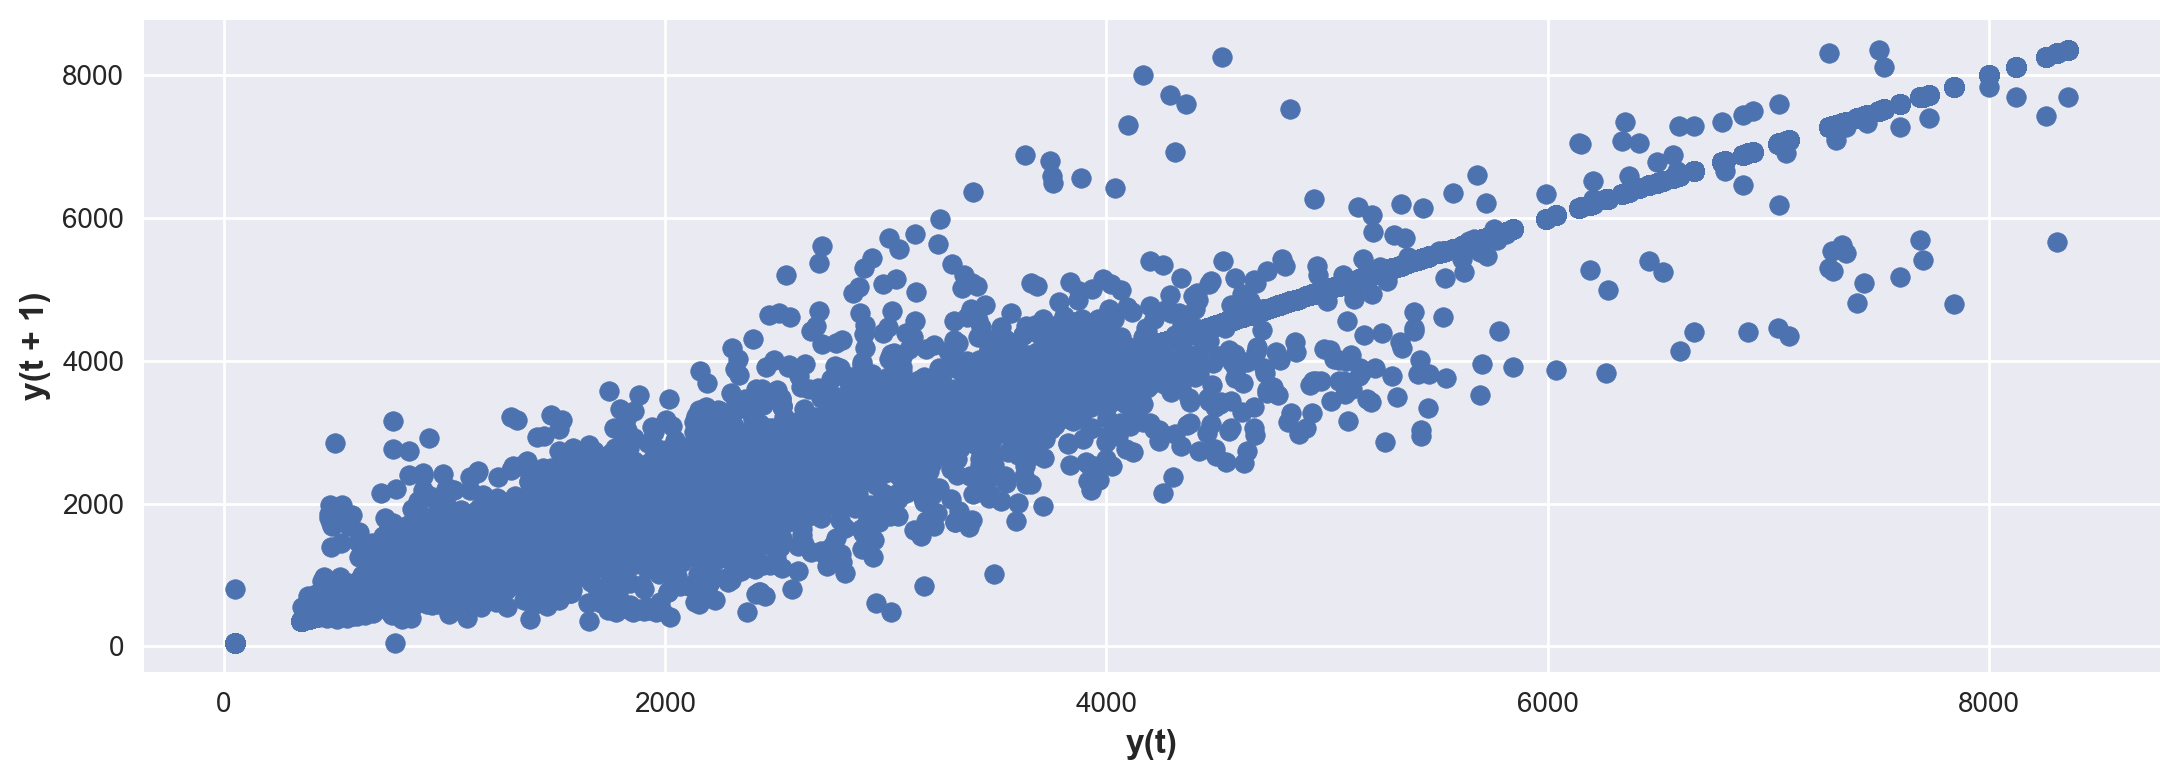

In [104]:
# Create a lag plot

pd.plotting.lag_plot(train_merged['transactions'], lag=1)

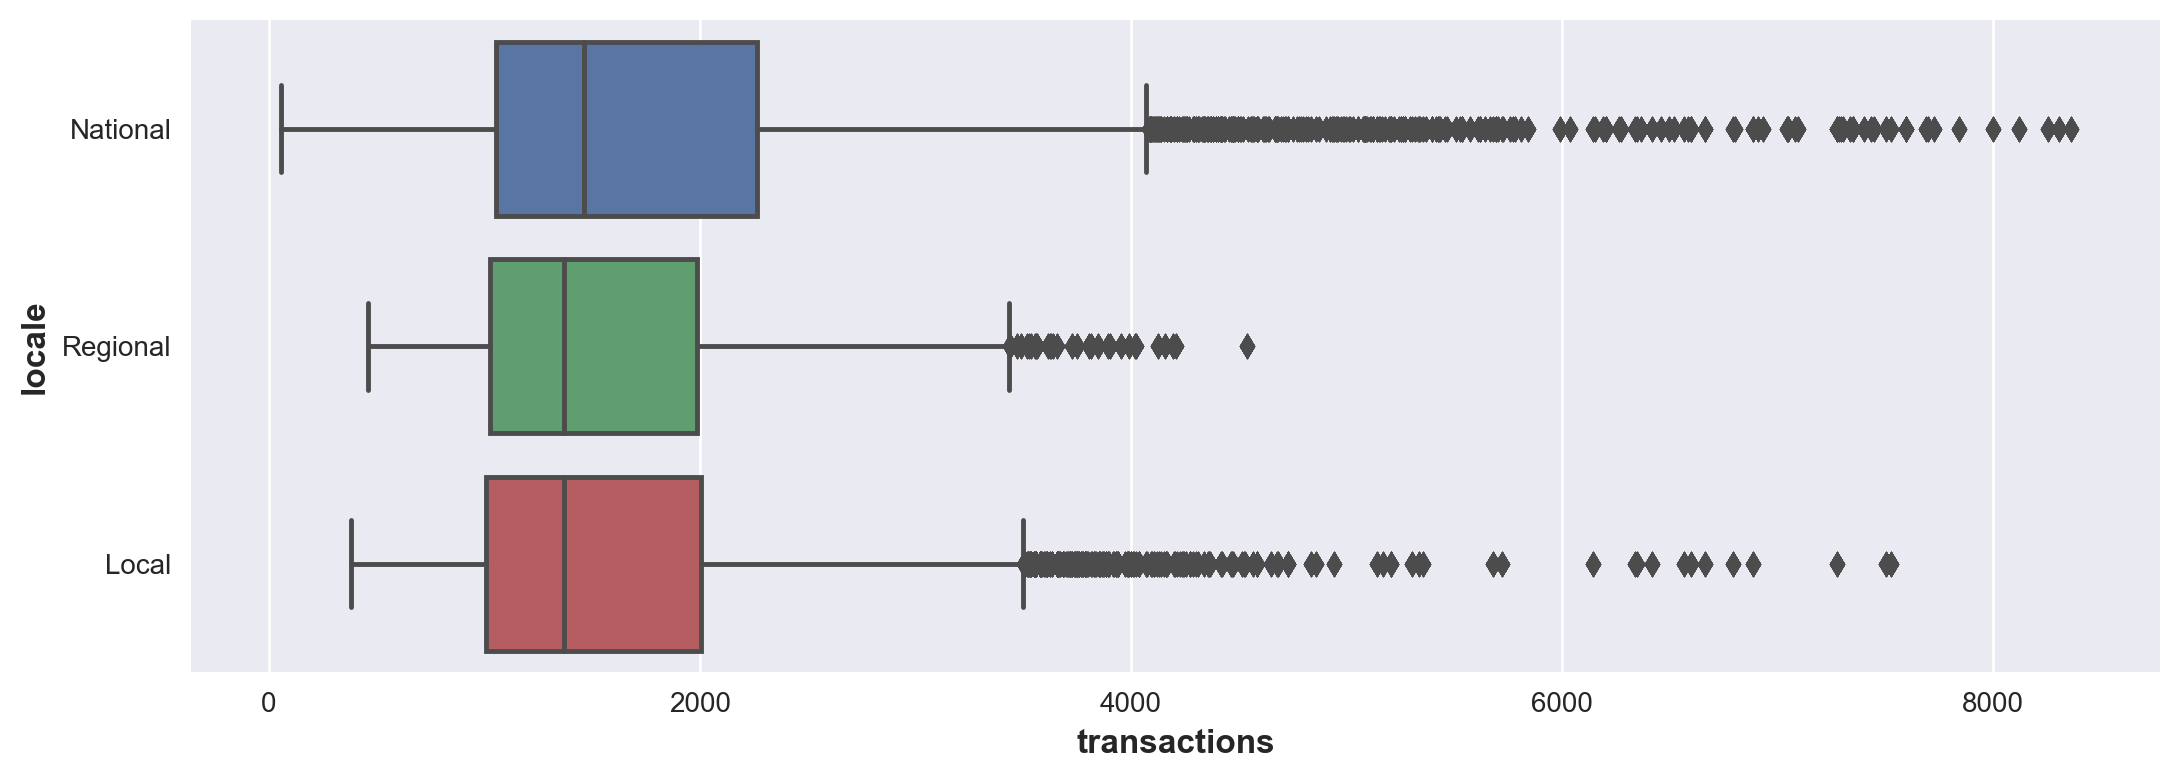

In [42]:
# Create a boxplot of the 'transactions' column grouped by 'locale'
sns.boxplot(x='transactions', y='locale', data=train_merged)

# Show the plot
plt.show()

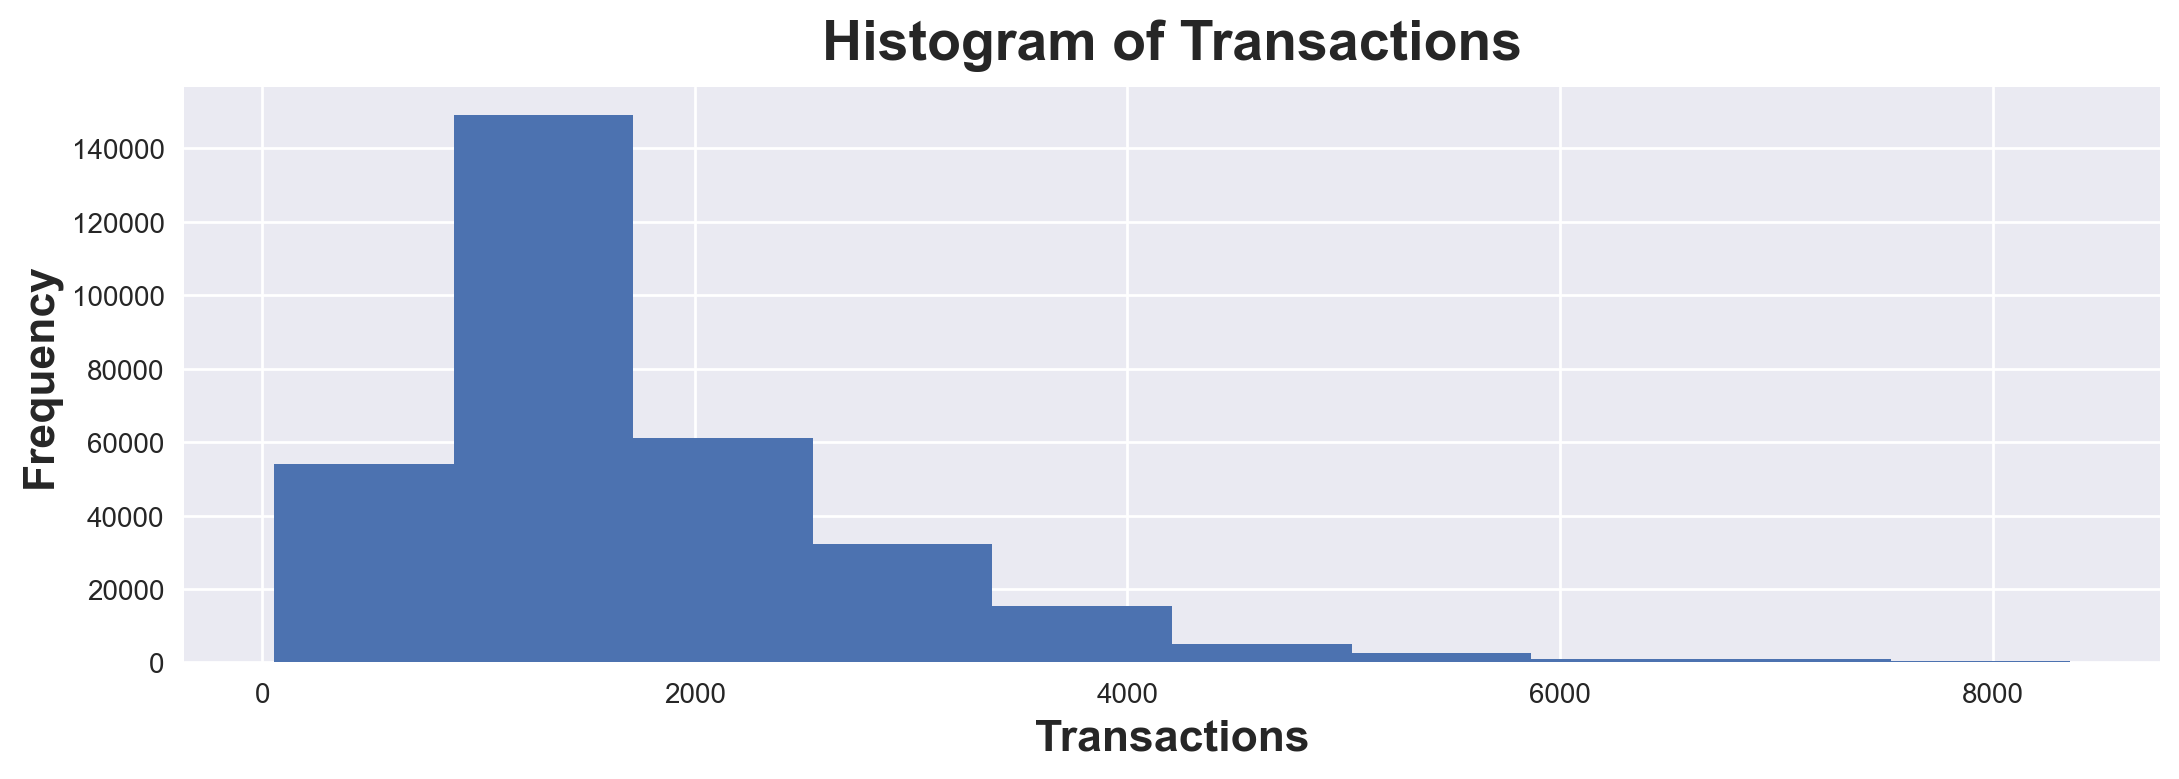

In [44]:
# Create a histogram of the 'transactions' column
train_merged.transactions.hist()

# Add labels to the x-axis, y-axis, and title
plt.xlabel('Transactions', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Histogram of Transactions', fontsize=20)

# Show the plot
plt.show()

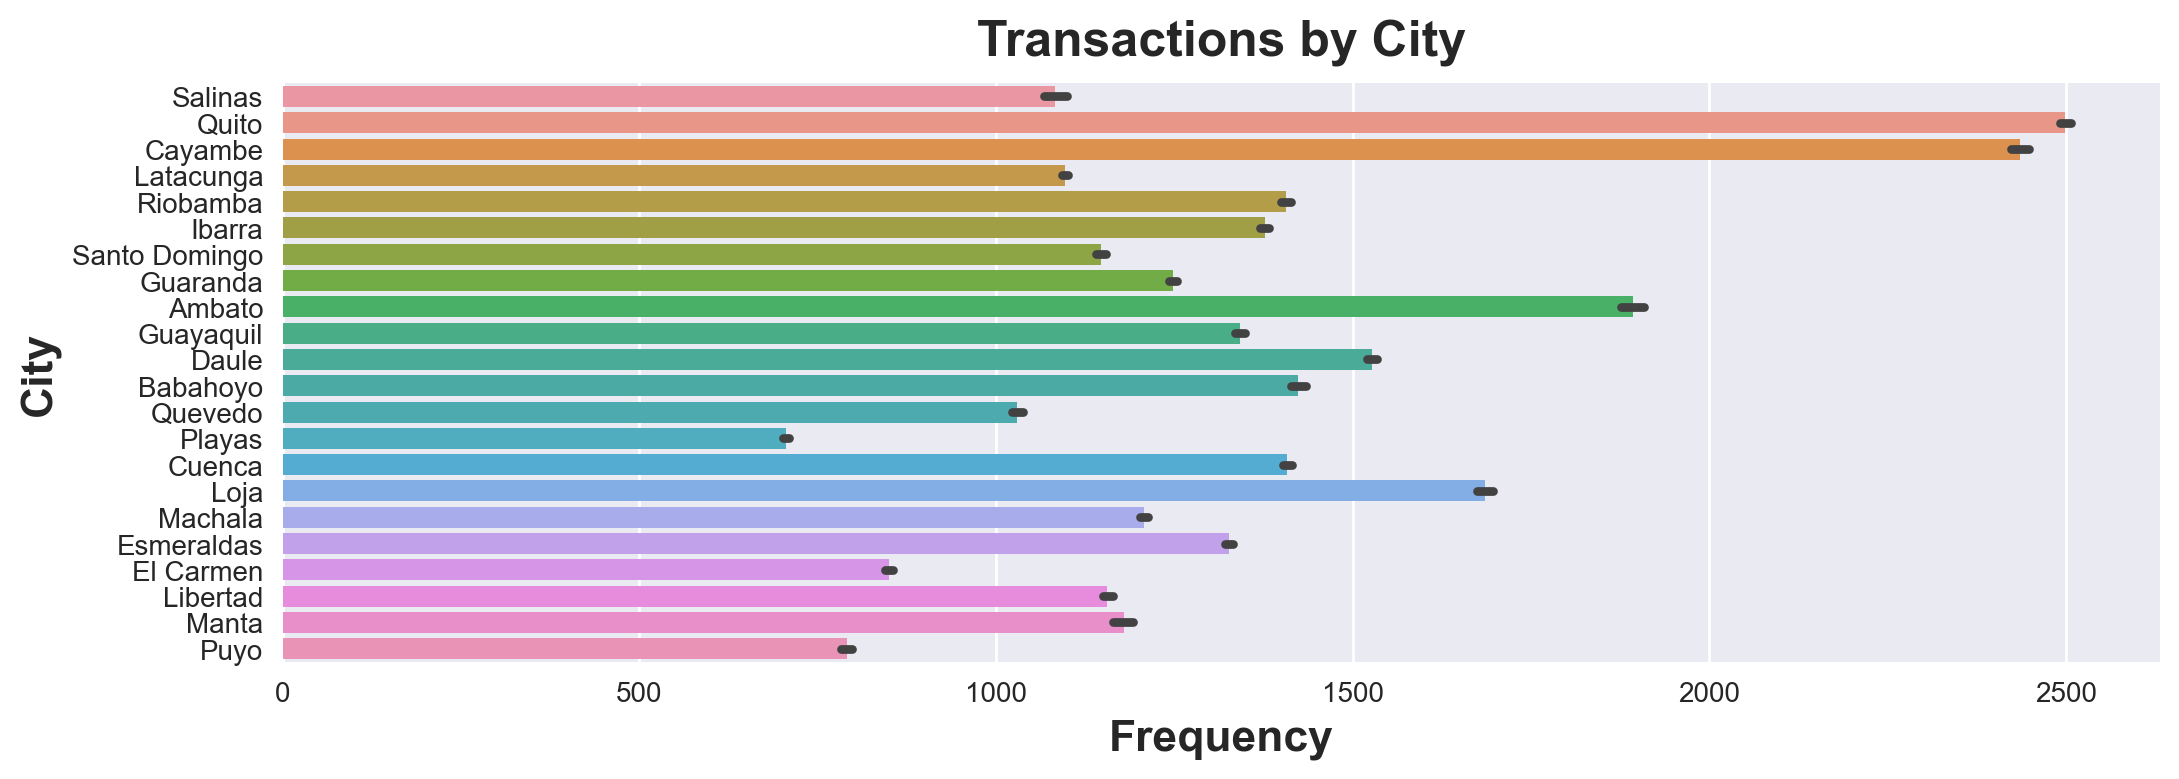

In [75]:
# Create a boxplot of transactions by City
sns.barplot(x='transactions', y='city', data=train_merged)

width=0.5,  # Adjust the width of the boxes
fliersize=3, # Adjust the size of the outliers
showmeans=True, # Show the mean value
meanline=True, # Show a line for the mean
notch=True, # Make the boxes "notched"

# Add a title and labels for the x and y axis
plt.title('Transactions by City', fontsize=18)
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('City', fontsize=16)

# Show the plot
plt.show()

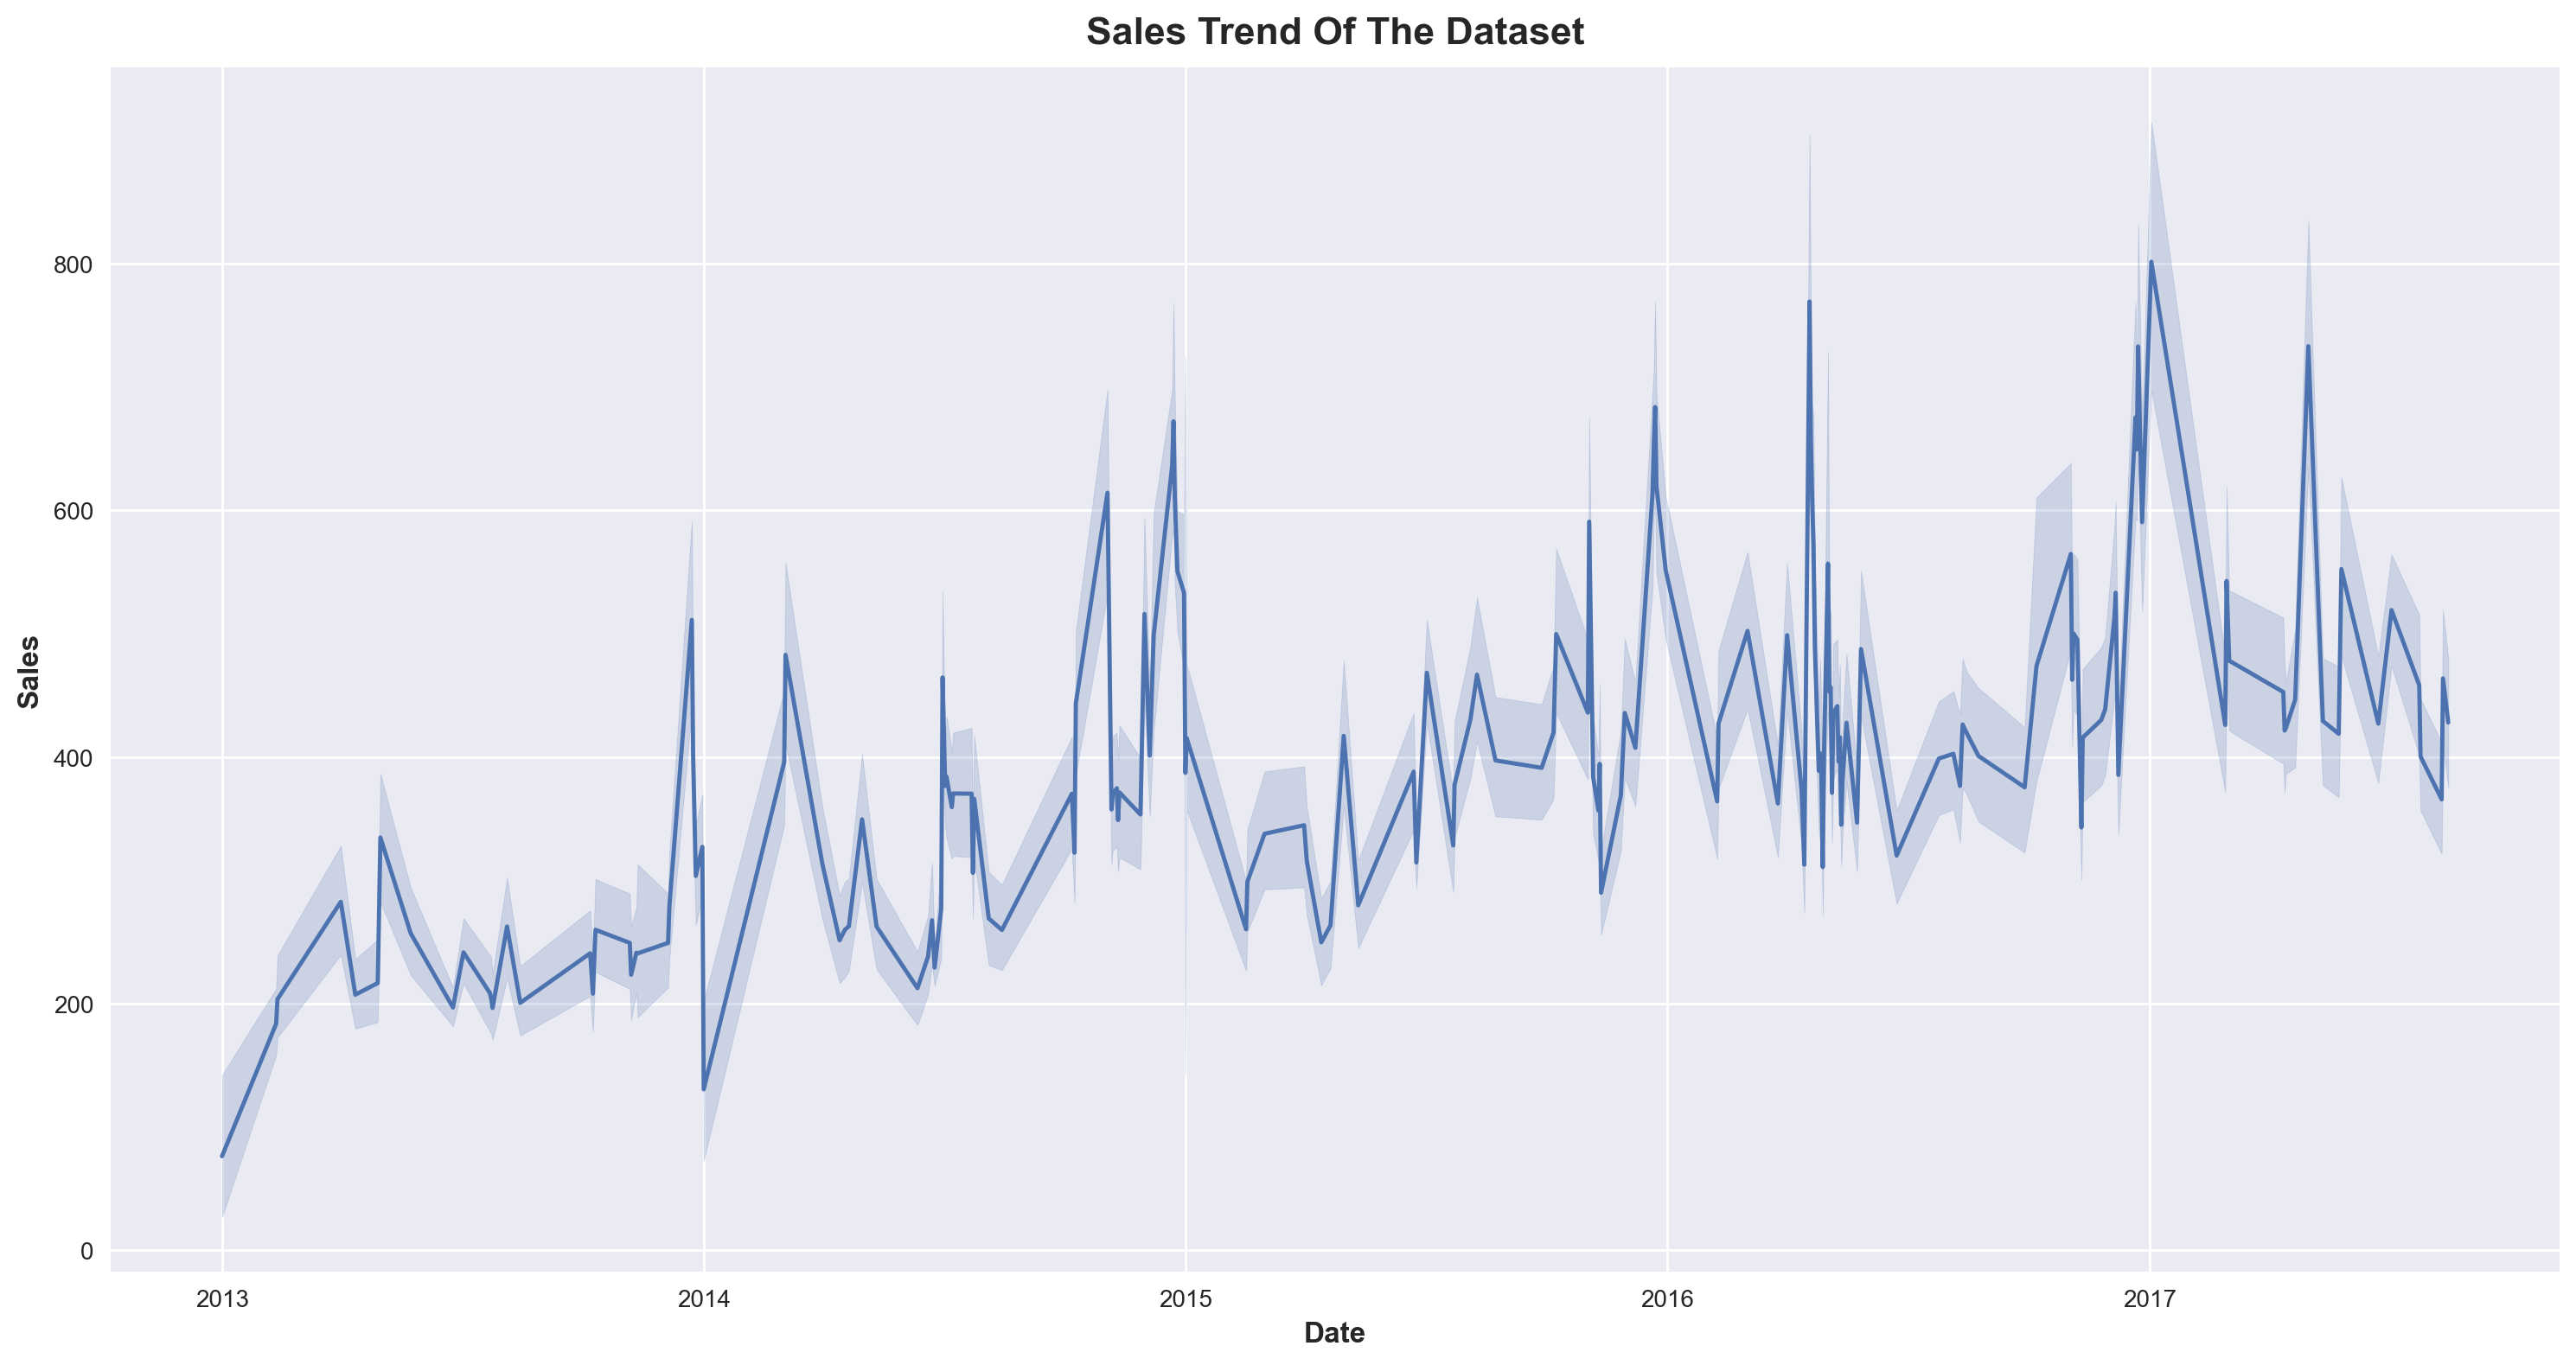

In [111]:
# Visualize the sales trend of the dataset

plt.figure(figsize=(15,8))
sns.lineplot(x='date', y='sales', data=train_merged)
plt.title('Sales Trend Of The Dataset')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

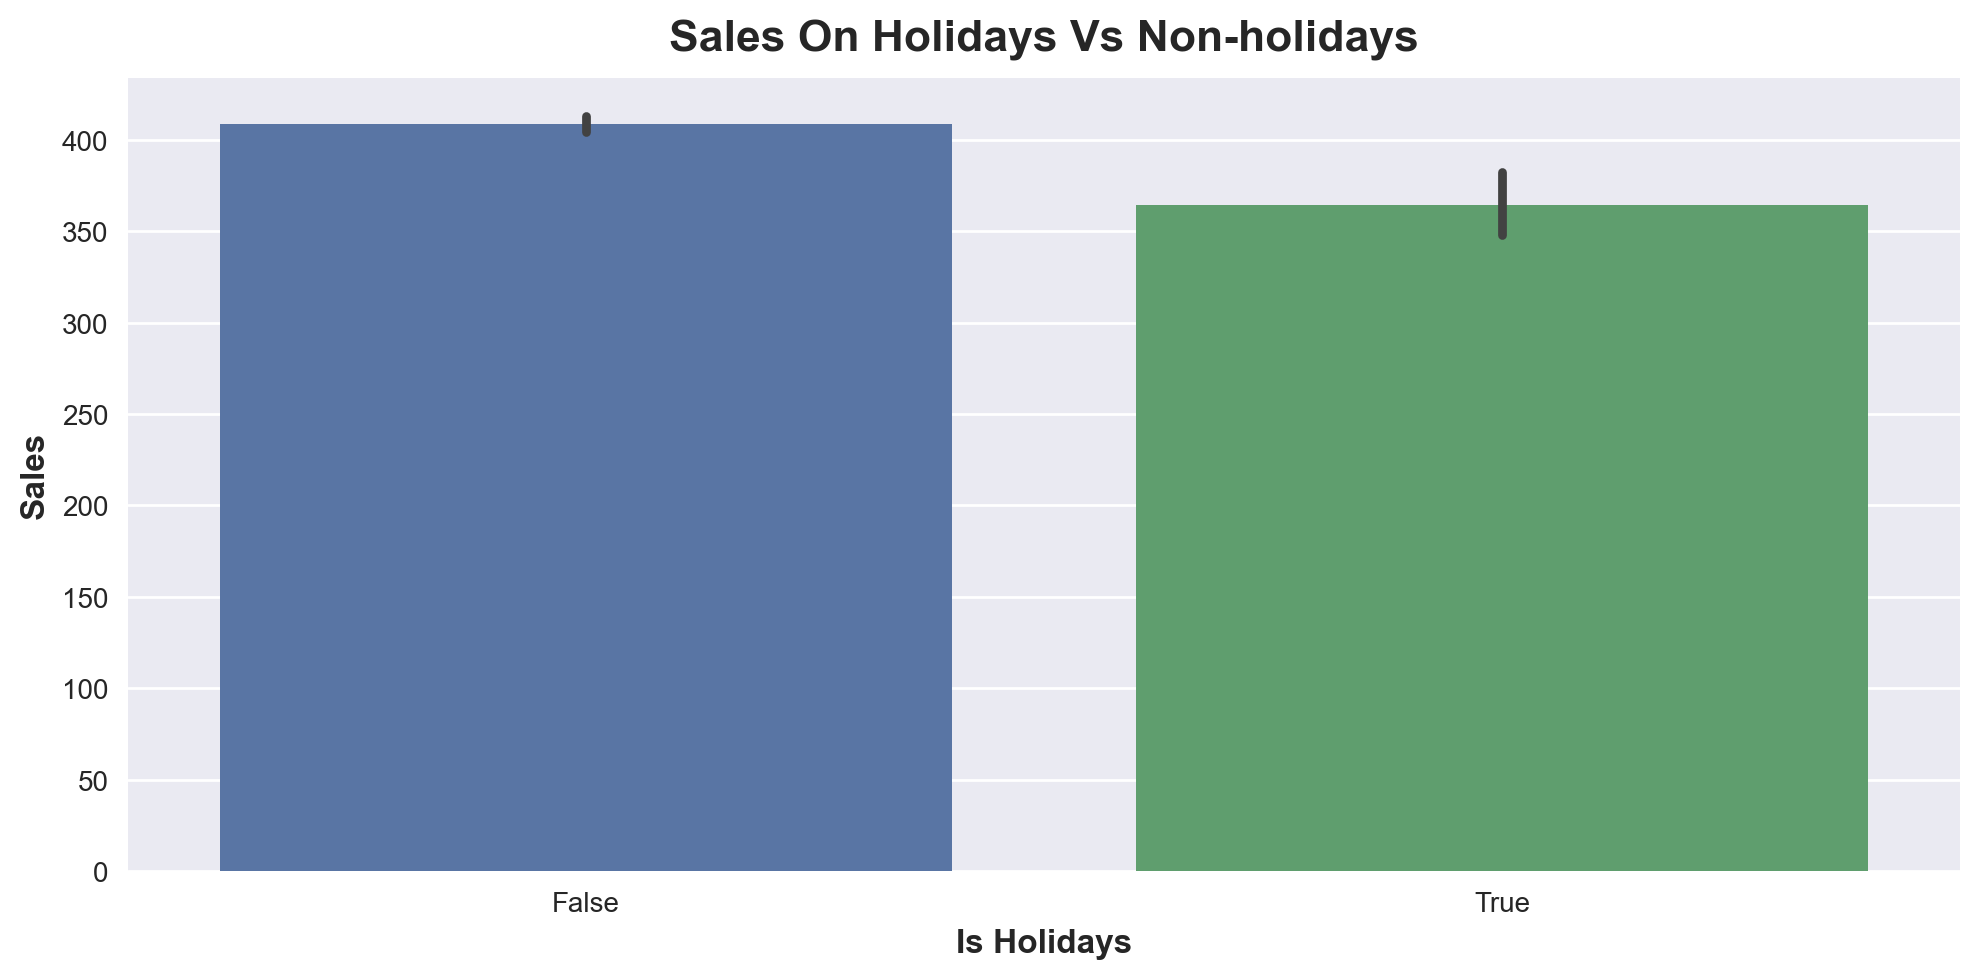

In [77]:
# Compare the sales on holidays with sales on non-holidays

plt.figure(figsize=(10,5))
sns.barplot(x='transferred', y='sales', data=train_merged)
plt.title('Sales On Holidays Vs Non-holidays')
plt.xlabel('Is Holidays')
plt.ylabel('Sales')
plt.show()

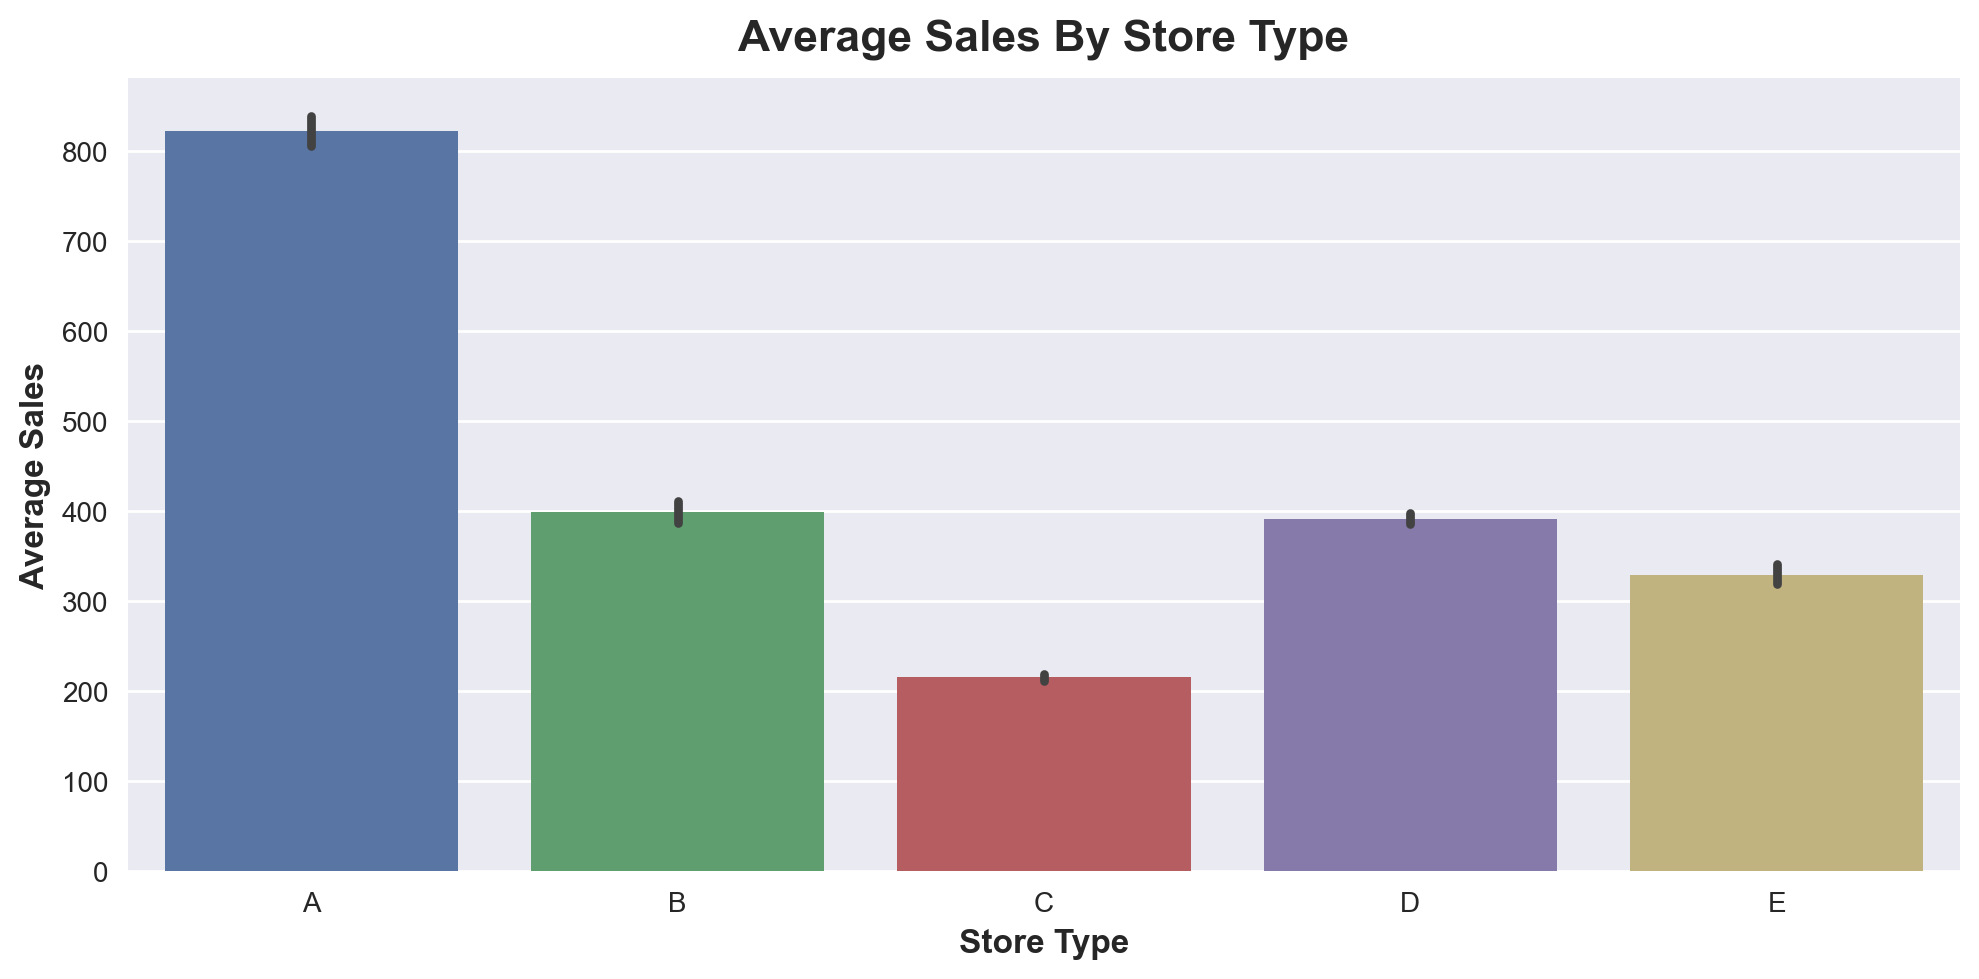

In [83]:
# Visualize the average sales for each store_type

store_types = ['A', 'B', 'C', 'D', 'E']

plt.figure(figsize=(10,5))
sns.barplot(x='store_type', y='sales', data=train_merged, order=store_types)
plt.title('Average Sales By Store Type')
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.show()

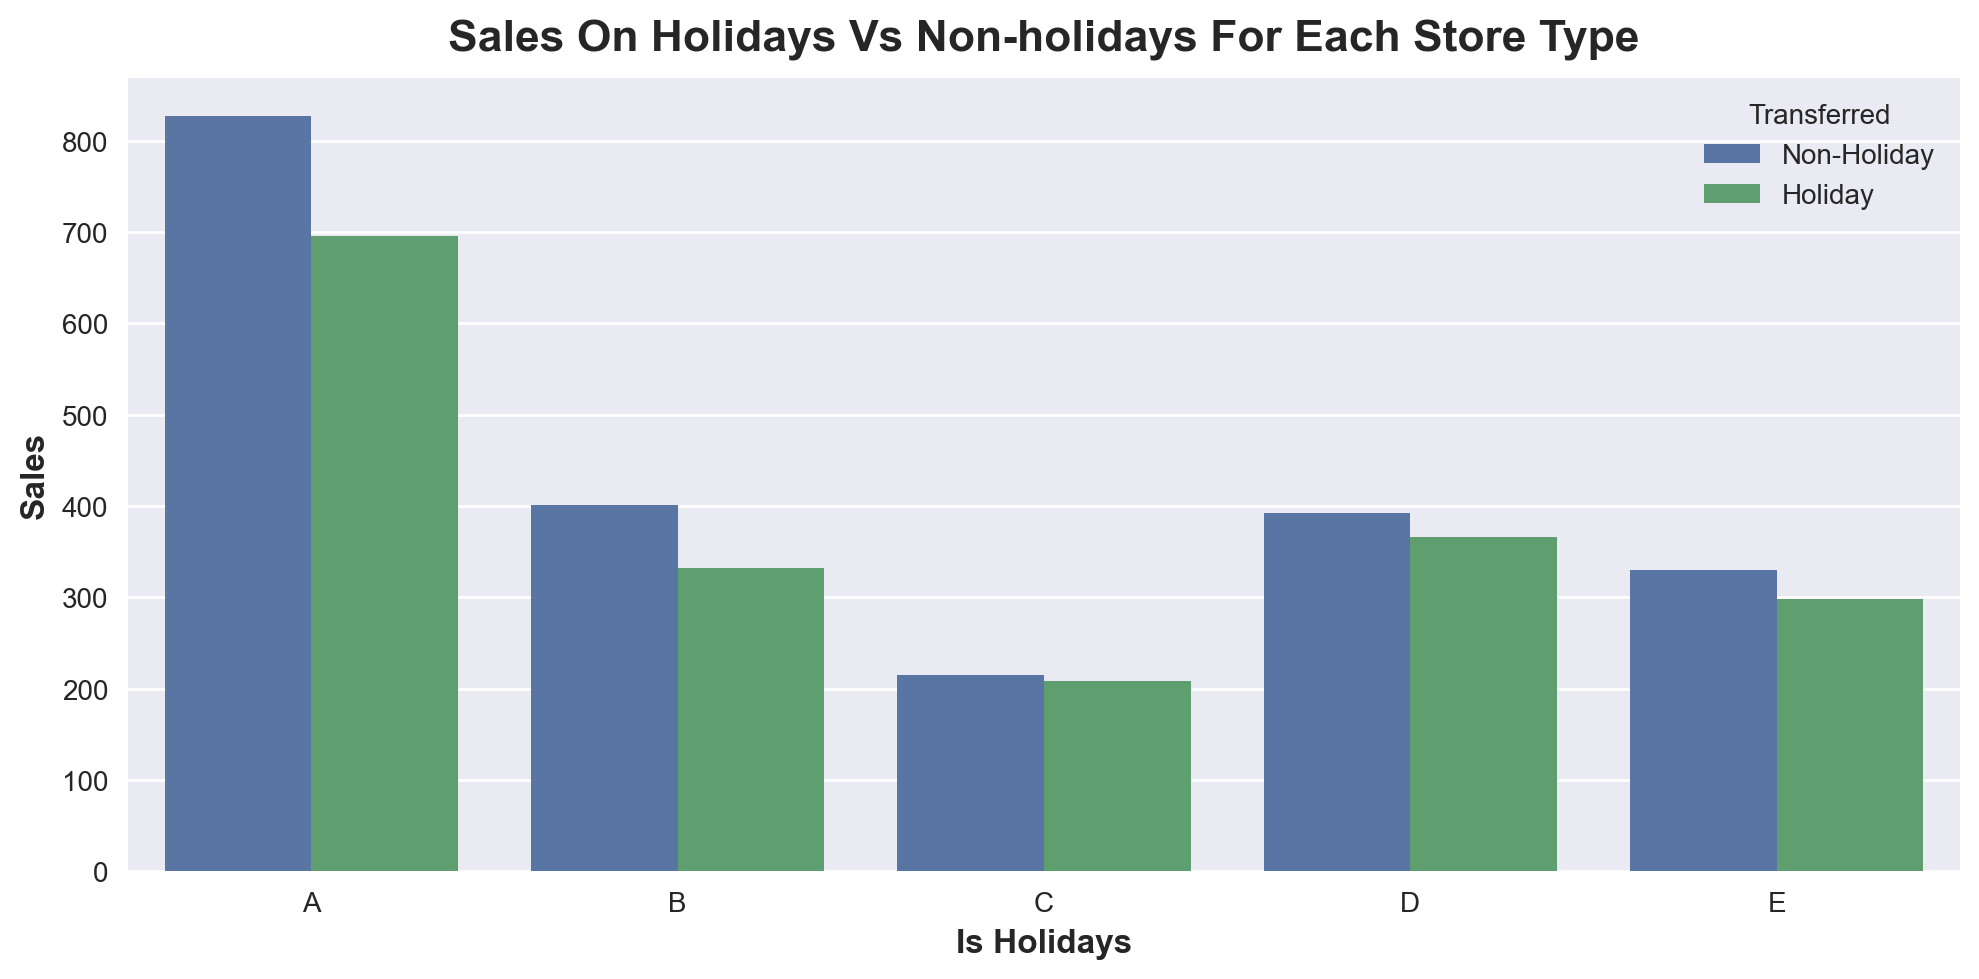

In [86]:
# Compare the sales on holidays with sales on non-holidays

plt.figure(figsize=(10,5))
sns.barplot(x='store_type', hue='transferred', y='sales', data=train_merged, ci=None, order=store_types)
plt.title('Sales On Holidays Vs Non-holidays For Each Store Type')
plt.xlabel('Is Holidays')
plt.ylabel('Sales')
plt.legend(title='Transferred', labels=['Non-Holiday', 'Holiday'])
plt.show()

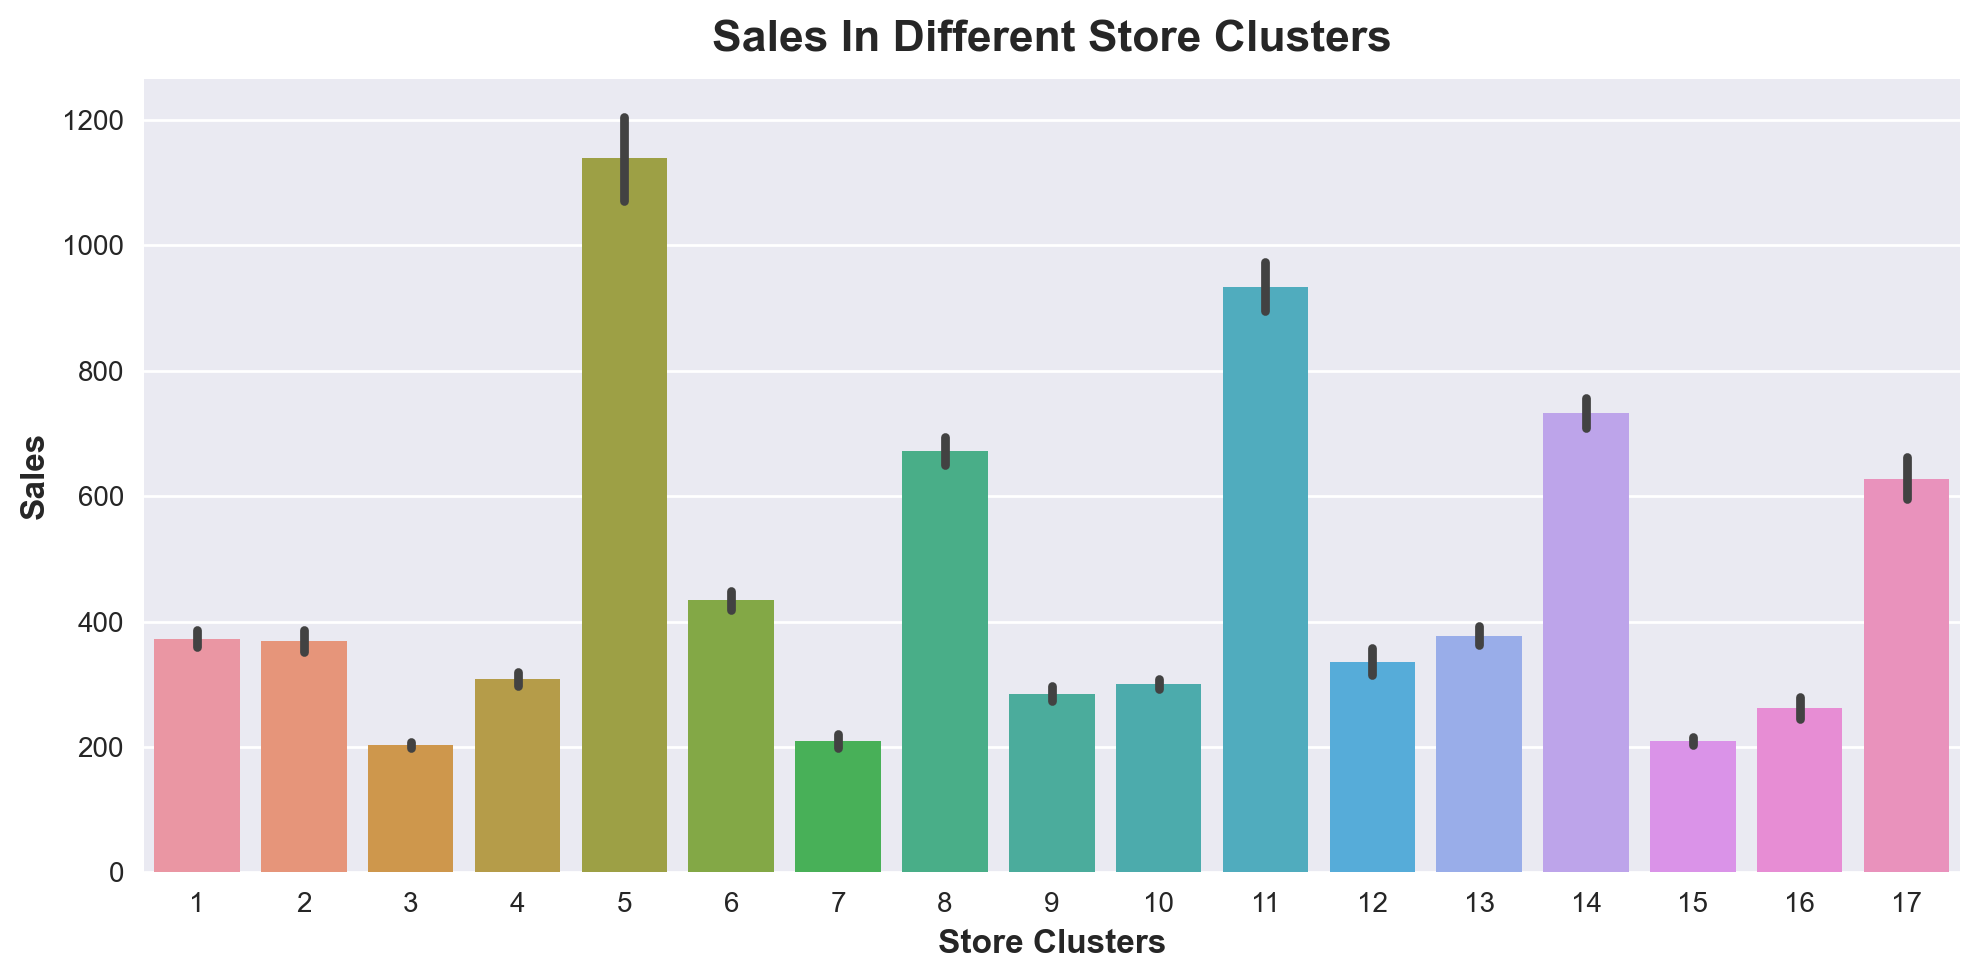

In [73]:
# Compare the sales in the different store clusters

plt.figure(figsize=(10,5))
sns.barplot(x='cluster', y='sales', data=train_merged)
plt.title('Sales In Different Store Clusters')
plt.xlabel('Store Clusters')
plt.ylabel('Sales')
plt.show()

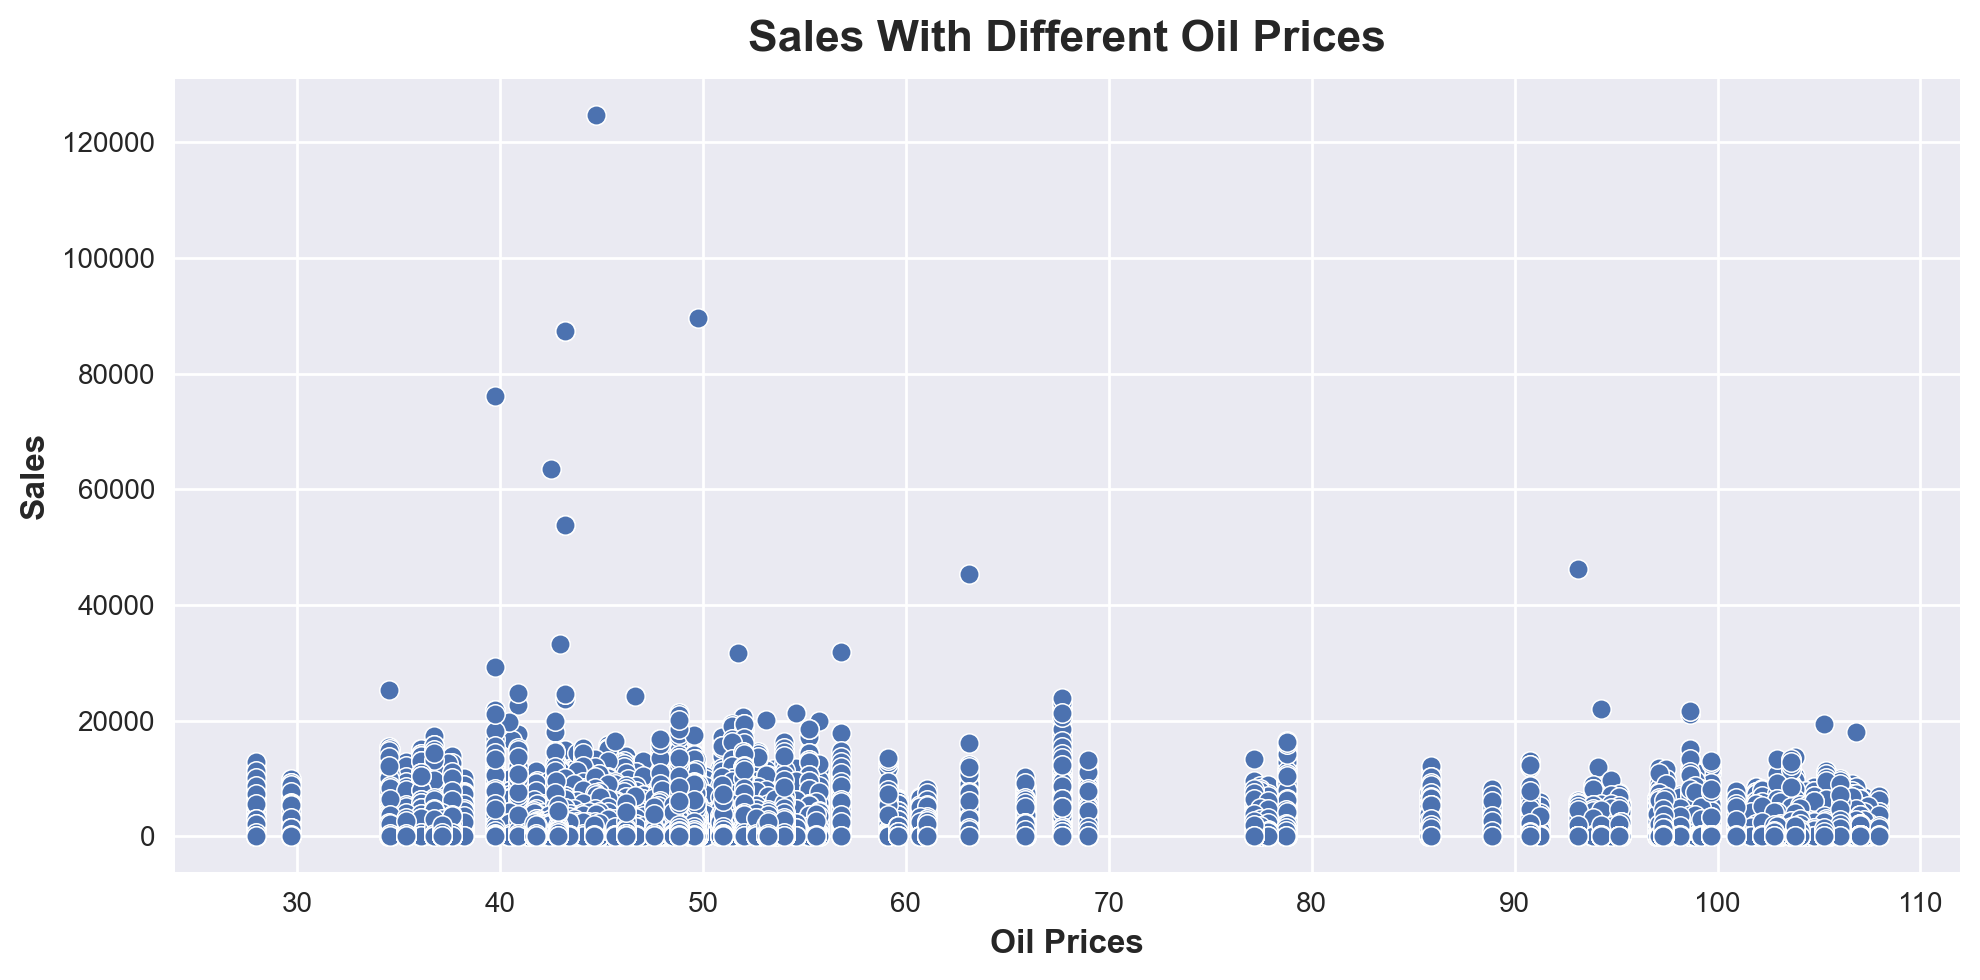

In [81]:
# Compare the sales with oil prices

plt.figure(figsize=(10,5))
sns.scatterplot(x='dcoilwtico', y='sales', data=train_merged)
plt.title('Sales With Different Oil Prices')
plt.xlabel('Oil Prices')
plt.ylabel('Sales')
plt.show()

We can observe that majority of the data points are evenly distributed on the scatterplot around some specific oil prices and sales values. There are a few outliers though which may have been caused by activities not related to oil prices.

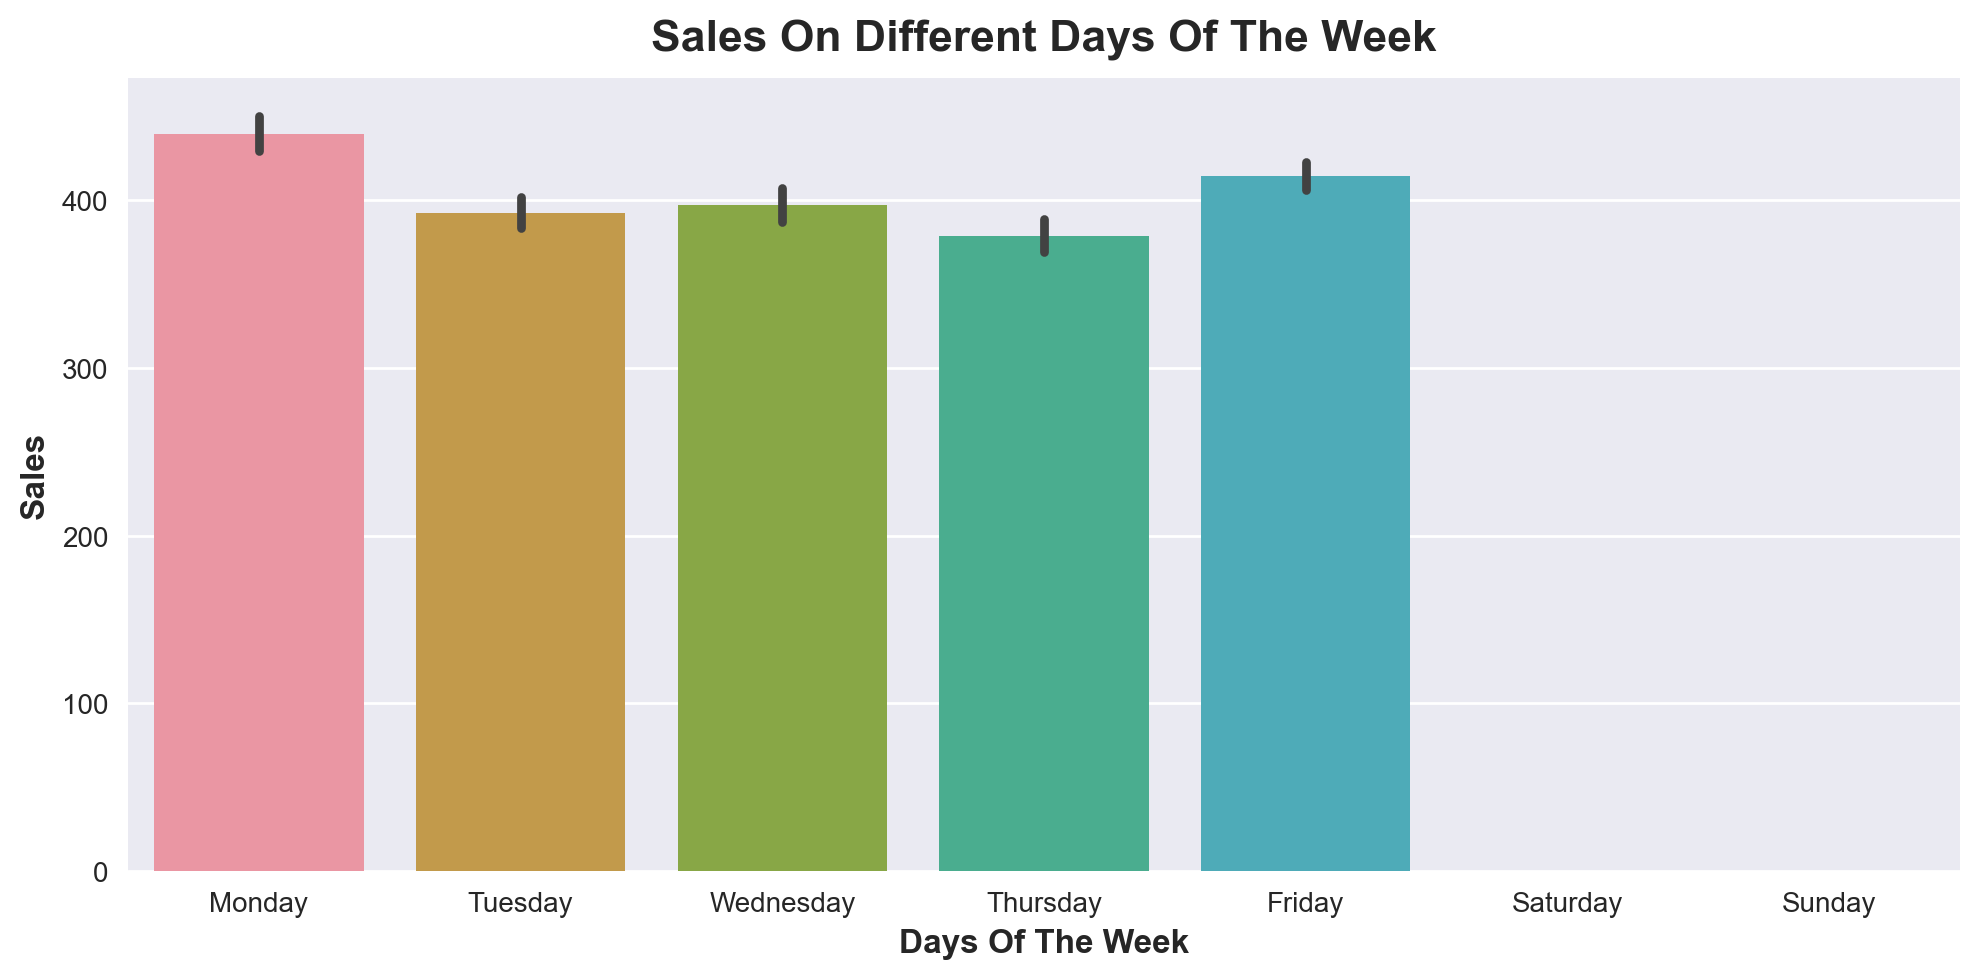

In [90]:
# Compare average sales on different days of the week

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10,5))
sns.barplot(x='dayname', y='sales', data=train_merged, order=weekdays)
plt.title('Sales On Different Days Of The Week')
plt.xlabel('Days Of The Week')
plt.ylabel('Sales')
plt.show()

<Axes: >

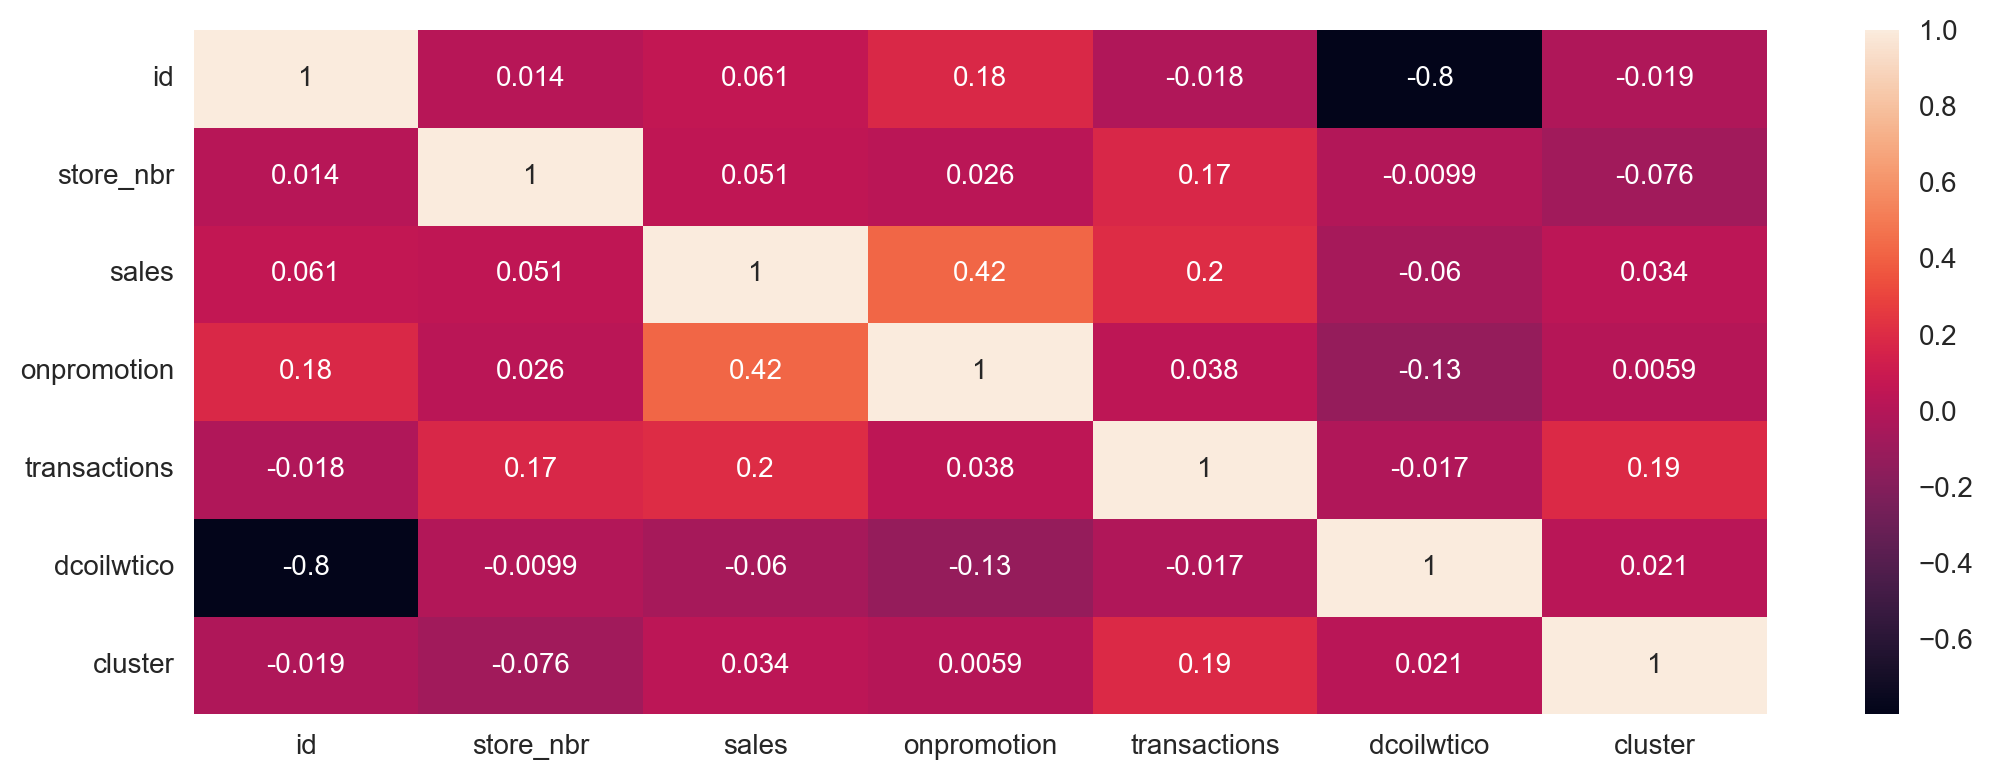

In [105]:
# Create a DataFrame of train_data with numerical columns only
train_merged_num = train_merged.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix of the numerical columns
corr_matrix = train_merged_num.corr()

# Visualizing the correlation matrix with a heatmap
sns.heatmap(corr_matrix, annot=True)

# Save the chart as an image file
# plt.savefig('Correlation of the numerical columns of the train dataset.png')

# Hypothesis Testing

# Answering Analytical Questions

### Questions

1. Is the train dataset complete (has all the required dates)?

2. Which dates have the lowest and highest sales for each year?

3. Did the earthquake impact sales?

4. Are certain groups of stores selling more products? (Cluster, city, state, type)

5. Are sales affected by promotions, oil prices and holidays?

6. What analysis can we get from the date and its extractable features?

7. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

### Question 1

Is the train dataset complete (has all the required dates)?

In [55]:
# Check for missing values in train dataset
if train.isnull().values.any():
  print("The dataset is not complete. There are missing values.")

# Check for duplicate dates in train dataset
if not train.index.is_unique:
  print("The dataset is not complete. There are duplicate dates.")
else:
  print("The dataset is complete.")

The dataset is complete.


### Question 2

Which dates have the lowest and highest sales for each year?

In [56]:
# Group the data by year and get the minimum and maximum sales for each year
grouped_by_year = df4.groupby('year')['sales'].agg(['min', 'max'])

# Get the dates corresponding to the minimum and maximum sales for each year
result = pd.concat([df4[df4['sales'] == grouped_by_year.loc[year, 'min']][['year', 'date']].rename(columns={'date': 'date_min'}) for year in grouped_by_year.index] +
                  [df4[df4['sales'] == grouped_by_year.loc[year, 'max']][['year', 'date']].rename(columns={'date': 'date_max'}) for year in grouped_by_year.index])

# Set the 'year' column as index
result = result.set_index('year')

# Group the data by year to get the minimum and maximum sales on separate rows
result = result.groupby(level=0).agg({'date_min': 'first', 'date_max': 'first'})

# Reset the index to get a regular dataframe
result = result.reset_index()

# Show the lowest and highest sales for each year
result

year   date_min   date_max
0  2013 2013-01-01 2013-11-12
1  2014 2014-01-01 2014-12-08
2  2015 2015-01-01 2015-11-11
3  2016 2016-02-08 2016-05-02
4  2017 2017-01-02 2017-01-02

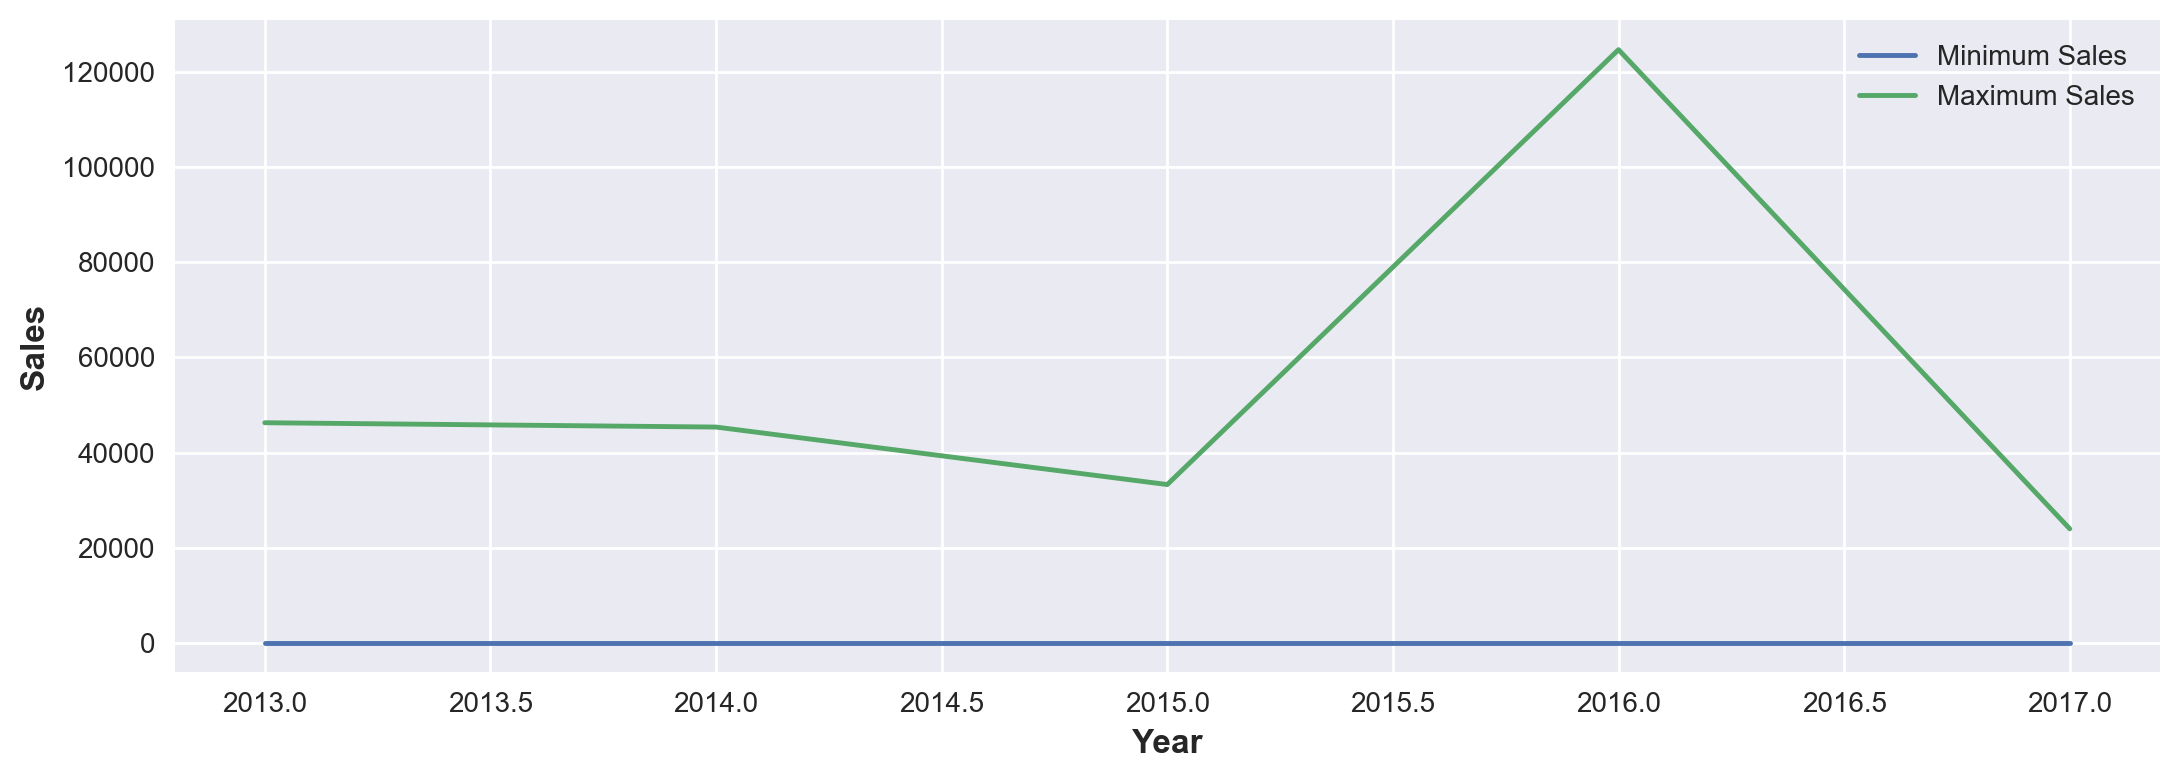

In [57]:
# Plot the minimum and maximum sales for each year
plt.plot(result['year'], grouped_by_year['min'], label='Minimum Sales')
plt.plot(result['year'], grouped_by_year['max'], label='Maximum Sales')

# Add a legend
plt.legend()

# Add axis labels
plt.xlabel('Year')
plt.ylabel('Sales')

# Show the plot
plt.show()

### Question 3

Did the earthquake impact sales?

### Question 4

Are certain groups of stores selling more products? (Cluster, city, state, type)

In [58]:
# Display random sample of 3 rows

train_merged.sample(5, random_state = 42)

id  store_nbr           family  sales  onpromotion   
date                                                                  
2017-05-12  2830580         30     BREAD/BAKERY  143.0            2  \
2013-11-06   551707         39       GROCERY II   28.0            0   
2017-03-02  2704338         38         LINGERIE    8.0            0   
2016-05-13  2184356         48  LAWN AND GARDEN    6.0            0   
2013-06-25   312431         25  LAWN AND GARDEN    2.0            0   

            transactions holiday_type    locale   
date                                              
2017-05-12           743      Holiday     Local  \
2013-11-06          1275      Holiday  Regional   
2017-03-02          1426      Holiday     Local   
2016-05-13          2438        Event  National   
2013-06-25           515      Holiday     Local   

                               locale_name   
date                                         
2017-05-12                            Puyo  \
2013-11-06  Santo Domingo de los Tsachilas   
2017-03-02                           Manta   
2016-05-13                         Ecuador   
2013-06-25                       Latacunga   

                                   description  ...  dcoilwtico       city   
date                                            ...                          
2017-05-12              Cantonizacion del Puyo  ...   47.830002  Guayaquil  \
2013-11-06  Provincializacion de Santo Domingo  ...   94.739998     Cuenca   
2017-03-02                  Fundacion de Manta  ...   52.630001       Loja   
2016-05-13                 Terremoto Manabi+27  ...   46.220001      Quito   
2013-06-25          Cantonizacion de Latacunga  ...   95.250000    Salinas   

                  state store_type cluster  year  month  dayofmonth   
date                                                                  
2017-05-12       Guayas          C       3  2017      5          12  \
2013-11-06        Azuay          B       6  2013     11           6   
2017-03-02         Loja          D       4  2017      3           2   
2016-05-13    Pichincha          A      14  2016      5          13   
2013-06-25  Santa Elena          D       1  2013      6          25   

            dayofweek    dayname  
date                              
2017-05-12          4     Friday  
2013-11-06          2  Wednesday  
2017-03-02          3   Thursday  
2016-05-13          4     Friday  
2013-06-25          1    Tuesday  

[5 rows x 21 columns]

In [59]:
# Group stores by cluster and count the family of products sold

cluster_products_count = train_merged.groupby(['cluster'], as_index=False).agg({'family':'count'}).sort_values('family', ascending=False)
cluster_products_count

cluster  family
2         3   44715
9        10   35574
5         6   32736
14       15   31812
13       14   25608
12       13   24354
3         4   19206
7         8   19206
0         1   18546
10       11   13233
8         9   12804
1         2    9603
6         7    9438
11       12    6402
4         5    6402
16       17    6402
15       16    6006

As seen in the DataFrame above, some clusters sell more products than others.

In [60]:
# Group stores by city and count the family of products sold

city_products_count = train_merged.groupby(['city'], as_index=False).agg({'family':'count'}).sort_values('family', ascending=False)
city_products_count

city  family
18          Quito  112266
8       Guayaquil   47784
21  Santo Domingo   16104
3          Cuenca   16005
13        Machala   12804
0          Ambato   12804
10      Latacunga   12606
6      Esmeraldas    6402
7        Guaranda    6402
5       El Carmen    6402
9          Ibarra    6402
1        Babahoyo    6402
12           Loja    6402
4           Daule    6402
15         Playas    6402
17        Quevedo    6402
2         Cayambe    6402
20        Salinas    6402
19       Riobamba    6336
11       Libertad    6237
14          Manta    5577
16           Puyo    3102

As seen in the DataFrame above, some cities sell more products than others.

In [61]:
# Group stores by state and count the family of products sold

state_products_count = train_merged.groupby(['state'], as_index=False).agg({'family':'count'}).sort_values('family', ascending=False)
state_products_count

state  family
12                       Pichincha  118668
6                           Guayas   66825
14  Santo Domingo de los Tsachilas   16104
0                            Azuay   16005
4                           El Oro   12804
9                         Los Rios   12804
15                      Tungurahua   12804
3                         Cotopaxi   12606
10                          Manabi   11979
1                          Bolivar    6402
5                       Esmeraldas    6402
7                         Imbabura    6402
8                             Loja    6402
13                     Santa Elena    6402
2                       Chimborazo    6336
11                         Pastaza    3102

As seen in the DataFrame above, some states sell more products than others.

In [62]:
# Group stores by store_type and count the family of products sold

store_type_product_count = train_merged.groupby(['store_type'], as_index=False).agg({'family':'count'}).sort_values('family', ascending=False)
store_type_product_count

store_type  family
3          D  110121
2          C   92367
0          A   51645
1          B   45144
4          E   22770

As seen in the DataFrame above, some store_types sell more products than others.

### Question 5

Are sales affected by promotions, oil prices and holidays?

In [63]:
# Create a copy of the train dataset
train_copy = train

Text(0, 0.5, 'Sales')

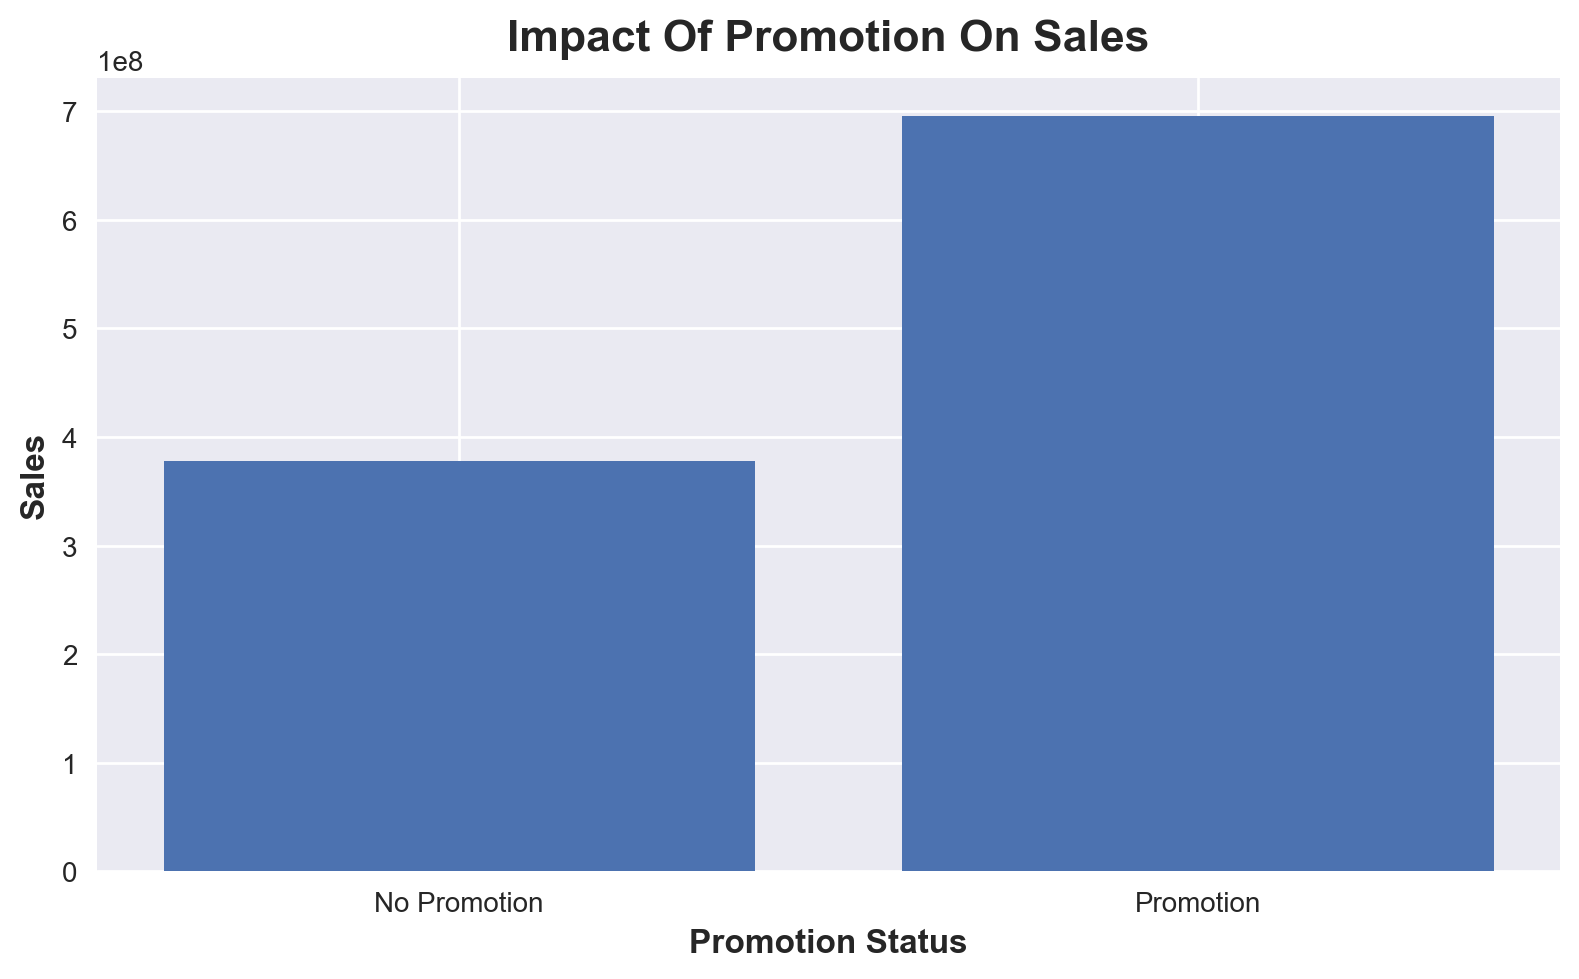

In [64]:
# Identify families with at least one item on promotion and families with no item on promotion
train_copy['onpromotion'] = train_copy['onpromotion'].apply(lambda x: 'No Promotion' if x == 0 else 'Promotion')

# Group by promotion and sum the sales
x = train_copy.groupby(['onpromotion'], as_index=False).agg({'sales':'sum'})

# Plot the sales of promotion and non_promotion families)
plt.figure(figsize=(8,5))
plt.bar(x.onpromotion, x.sales)
plt.title('Impact Of Promotion On Sales')
plt.xticks((0,1))
plt.xlabel('Promotion Status')
plt.ylabel('Sales')

From the chart above, product families with at least one item on promotion had greater sales than families with no item on promotion. This means that sales were affected by promotion.

### Question 6

What analysis can we get from the date and its extractable features?

### Question 7

What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

### Question 8

What is the total sales made each year by the corporation?

In [65]:
# Group by year and sum of sales for each year

sales_per_year = train_merged.groupby(['year'], as_index=False).agg({'sales':'sum'})
sales_per_year

year         sales
0  2013  1.166394e+07
1  2014  2.809424e+07
2  2015  2.752824e+07
3  2016  4.566470e+07
4  2017  1.792345e+07

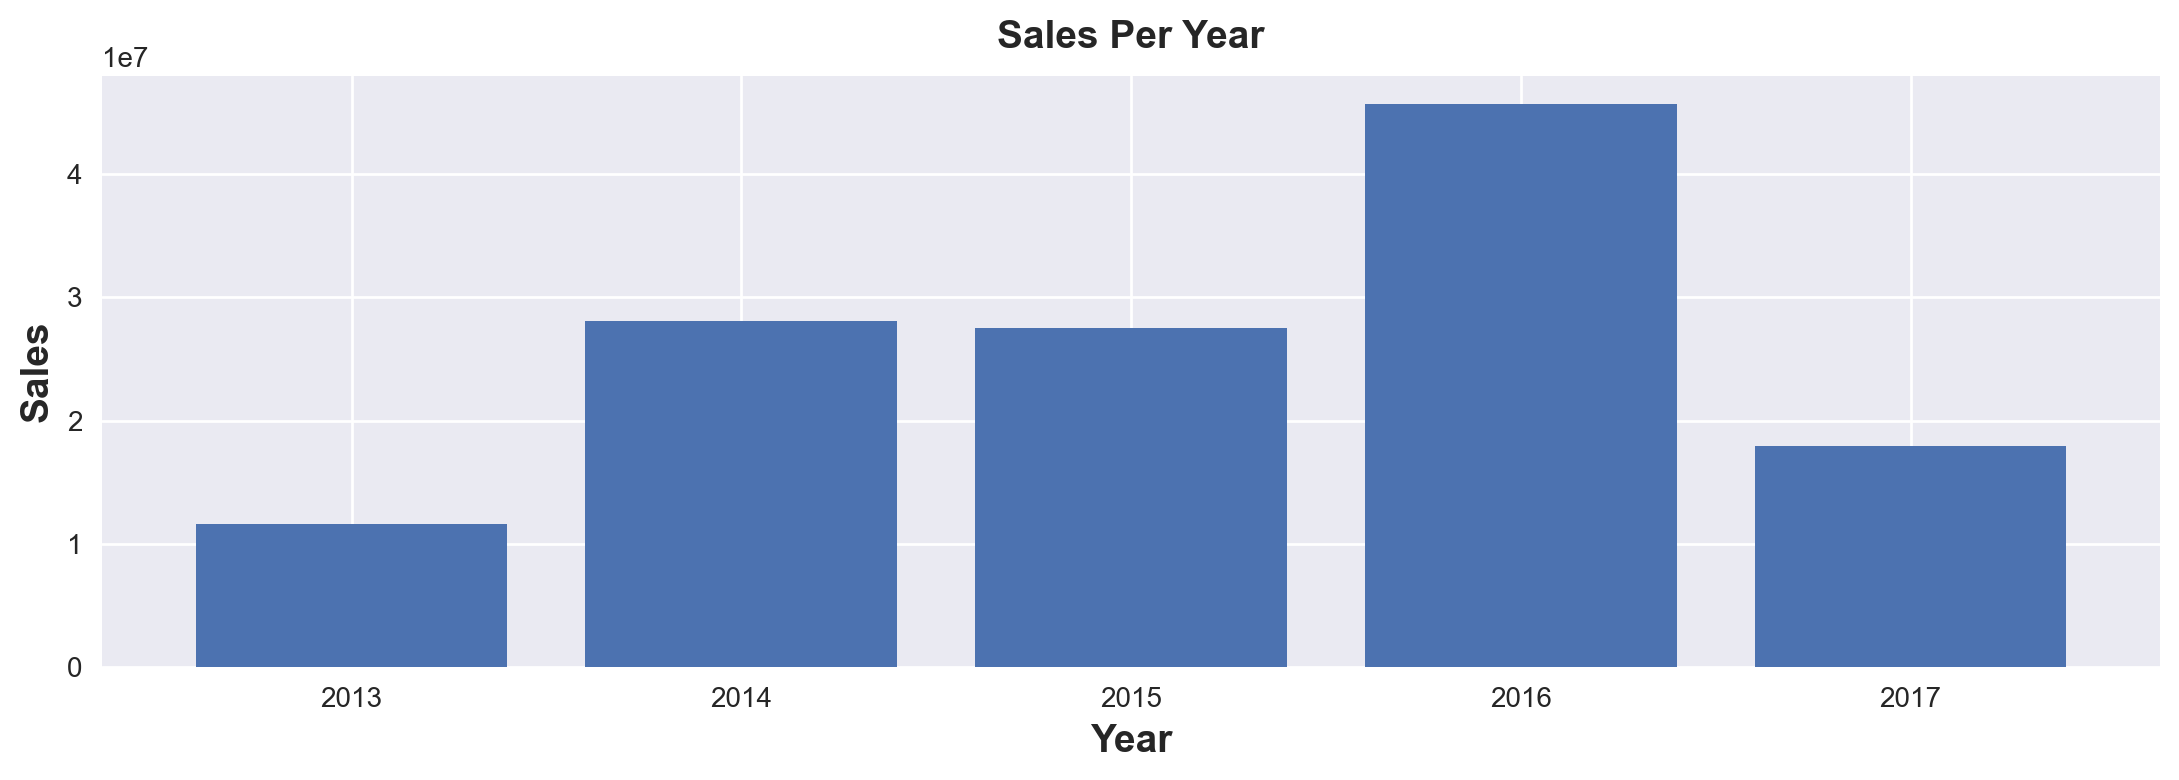

In [66]:
# Plot the sales made each year

plt.bar(sales_per_year.year, sales_per_year.sales)
plt.title('Sales Per Year',fontsize=14)
plt.ylabel('Sales',fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.show()

From the data provided, Corporation Favorita made it's lowest sales in 2013 and its highest sales in 2016.